# EDA


The World Restaurants dataset is a large-scale, real-world collection of restaurant reviews and associated metadata sourced from various users and venues globally. It is composed of four main CSV files: reviews.csv, which contains written reviews, ratings, categories, and timestamps; review_sentiments.csv, which includes sentiment analysis scores derived from those reviews (overall sentiment, emotion scores, and magnitudes); users.csv, which provides anonymized user profiles with attributes like education, location, and job information; and places.csv, which holds metadata about the restaurants, such as name, price range, phone number, and whether the establishment is currently closed. Together, this dataset offers a rich and diverse foundation for building recommendation systems, sentiment analysis models, and consumer behavior studies in the food and hospitality domain.



### Step 0: Load imports


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud, STOPWORDS
import ast
import warnings
warnings.filterwarnings("ignore")
import plotly.io as pio
import os
import glob
from sklearn.cluster import KMeans


### Step 1: Load the Dataset from Kaggle 


In [3]:
#get api token from ckaggle and settings
# mkdir -p ~/.kaggle
# mv ~/Downloads/kaggle.json ~/.kaggle/
# chmod 600 ~/.kaggle/kaggle.json

In [4]:
# Authenticate Kaggle API
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

# Download and unzip dataset
dataset_path = 'danielkumlin/world-restaurants'
api.dataset_download_files(dataset_path, path='data/', unzip=True)

# List all CSV files
csv_files = glob.glob('data/*.csv')
print("Downloaded CSV files:", csv_files)



Dataset URL: https://www.kaggle.com/datasets/danielkumlin/world-restaurants
Downloaded CSV files: ['data/reviews.csv', 'data/users.csv', 'data/places.csv', 'data/review_sentiments.csv']


### Step 2: Decreasing and merging dataset

This dataset we created and sourced is extremally large with around 700,000 datapoints, therefore we will be using around 30% for the original.

In [ ]:
import pandas as pd
import os
from langdetect import detect
from collections import Counter

# ---------- Load raw data ----------
reviews = pd.read_csv("data/reviews.csv", nrows=100000000000, engine='python', on_bad_lines='skip')
sentiments = pd.read_csv("data/review_sentiments.csv")
users = pd.read_csv("data/users.csv")
places = pd.read_csv("data/places.csv")

# ---------- Merge datasets ----------
df_merge = pd.merge(
    sentiments,
    reviews,
    how="left",
    left_on=["user_id", "restaurant_id"],
    right_on=["gPlusUserId", "gPlusPlaceId"]
)
df_merge = pd.merge(df_merge, users, how="left", left_on="user_id", right_on="gPlusUserId")
df_merge = pd.merge(df_merge, places, how="left", left_on="restaurant_id", right_on="gPlusPlaceId")

print("Initial merged shape:", df_merge.shape)

# ---------- Filter data ----------

# 1. Remove missing or empty review text
df_merge = df_merge[df_merge['reviewText'].notna()]
df_merge = df_merge[df_merge['reviewText'].str.strip() != ""]

# 2. Remove reviews with missing ratings
df_merge = df_merge[df_merge['rating'].notna()]

# 3. Keep only English reviews
def is_english(text):
    try:
        return detect(text) == "en"
    except:
        return False

print("Detecting English reviews — this may take a few minutes...")
df_merge["is_english"] = df_merge["reviewText"].apply(is_english)
df_merge = df_merge[df_merge["is_english"] == True]
df_merge.drop(columns=["is_english"], inplace=True)

# ---------- USER-FIRST APPROACH ----------
print("\nAnalyzing review distribution to optimize dataset...")

# Calculate review counts per user and restaurant
user_review_counts = df_merge["user_id"].value_counts()
restaurant_review_counts = df_merge["restaurant_id"].value_counts()

print(f"Initial statistics:")
print(f"Total users: {len(user_review_counts)}")
print(f"Total restaurants: {len(restaurant_review_counts)}")
print(f"Average reviews per user: {user_review_counts.mean():.2f}")
print(f"Average reviews per restaurant: {restaurant_review_counts.mean():.2f}")

# First, find users with many reviews
min_reviews_user = 5  # Start with high-activity users
print(f"\nUsers with {min_reviews_user}+ reviews: {sum(user_review_counts >= min_reviews_user)}")

# Start with users having most reviews, then expand if needed
active_users = user_review_counts[user_review_counts >= min_reviews_user].index

# Filter by these active users
user_filtered_df = df_merge[df_merge["user_id"].isin(active_users)]
print(f"Dataset after filtering for users with {min_reviews_user}+ reviews: {user_filtered_df.shape}")

# Now look at restaurants reviewed by these active users
active_restaurant_counts = user_filtered_df["restaurant_id"].value_counts()
print(f"Restaurants reviewed by active users: {len(active_restaurant_counts)}")
print(f"Average reviews per restaurant from active users: {active_restaurant_counts.mean():.2f}")

# See if any restaurants now have multiple reviews
print("\nRestaurant review count after user filtering:")
rest_dist = Counter(active_restaurant_counts.values)
for count, num in sorted(rest_dist.items(), reverse=True)[:10]:
    print(f"{count} reviews: {num} restaurants")

# Set a minimum threshold for restaurants (can be lower now)
min_reviews_restaurant = 2  # We want at least 2 reviews per restaurant
restaurants_with_min_reviews = active_restaurant_counts[active_restaurant_counts >= min_reviews_restaurant].index
print(f"\nRestaurants with {min_reviews_restaurant}+ reviews from active users: {len(restaurants_with_min_reviews)}")

# Final dataset with both filtered users and restaurants
final_df = user_filtered_df[user_filtered_df["restaurant_id"].isin(restaurants_with_min_reviews)]
print(f"Dataset after filtering for restaurants with {min_reviews_restaurant}+ reviews: {final_df.shape}")

# Final statistics
total_users = len(final_df["user_id"].unique())
total_restaurants = len(final_df["restaurant_id"].unique())
total_reviews = len(final_df)

print("\nFinal dataset statistics:")
print(f"Total users: {total_users}")
print(f"Total restaurants: {total_restaurants}")
print(f"Total reviews: {total_reviews}")

if total_users > 0 and total_restaurants > 0:
    total_possible_interactions = total_users * total_restaurants
    density = (total_reviews / total_possible_interactions) * 100
    avg_reviews_per_user = total_reviews / total_users
    avg_reviews_per_restaurant = total_reviews / total_restaurants
    
    print(f"Matrix density: {density:.4f}%")
    print(f"Average reviews per user: {avg_reviews_per_user:.2f}")
    print(f"Average reviews per restaurant: {avg_reviews_per_restaurant:.2f}")
    
    # Show user review distribution
    final_user_dist = Counter(final_df["user_id"].value_counts().values)
    print("\nFinal user review count distribution:")
    for count, freq in sorted(final_user_dist.items(), reverse=True)[:10]:
        print(f"{count} reviews: {freq} users")
    
    # Show restaurant review distribution
    final_restaurant_dist = Counter(final_df["restaurant_id"].value_counts().values)
    print("\nFinal restaurant review count distribution:")
    for count, freq in sorted(final_restaurant_dist.items(), reverse=True)[:10]:
        print(f"{count} reviews: {freq} restaurants")

# If the dataset is still too sparse, let's try a different approach
# Focus on getting a small but dense subset
if total_users == 0 or total_restaurants == 0 or density < 1.0:
    print("\nDataset is still too sparse. Trying a different approach...")
    
    # Start with the top N most active users
    top_n_users = 50
    top_users = user_review_counts.nlargest(top_n_users).index
    top_user_df = df_merge[df_merge["user_id"].isin(top_users)]
    
    # Find restaurants that have been reviewed by at least 2 of these top users
    top_restaurant_counts = top_user_df["restaurant_id"].value_counts()
    common_restaurants = top_restaurant_counts[top_restaurant_counts >= 2].index
    
    # Create a dense subset
    dense_df = top_user_df[top_user_df["restaurant_id"].isin(common_restaurants)]
    
    # Ensure each user still has enough reviews
    dense_user_counts = dense_df["user_id"].value_counts()
    active_dense_users = dense_user_counts[dense_user_counts >= 2].index
    dense_df = dense_df[dense_df["user_id"].isin(active_dense_users)]
    
    # Final dense statistics
    dense_users = len(dense_df["user_id"].unique())
    dense_restaurants = len(dense_df["restaurant_id"].unique())
    dense_reviews = len(dense_df)
    
    if dense_users > 0 and dense_restaurants > 0:
        dense_density = (dense_reviews / (dense_users * dense_restaurants)) * 100
        
        print("\nDense subset statistics:")
        print(f"Total users: {dense_users}")
        print(f"Total restaurants: {dense_restaurants}")
        print(f"Total reviews: {dense_reviews}")
        print(f"Matrix density: {dense_density:.4f}%")
        
        # Replace final_df with dense_df if the original was empty
        if total_users == 0 or total_restaurants == 0:
            final_df = dense_df
            print("Using dense subset as the final dataset.")

# ---------- Save final cleaned dataset ----------
output_dir = "recommender_data"
os.makedirs(output_dir, exist_ok=True)

if len(final_df) > 0:
    final_path = os.path.join(output_dir, "optimized_df.csv")
    final_df.to_csv(final_path, index=False)
    
    print(f"\nFinal optimized dataset saved to: {final_path}")
    print("Final shape:", final_df.shape)
    
    # Save user and restaurant IDs for reference
    final_users = final_df["user_id"].unique()
    final_restaurants = final_df["restaurant_id"].unique()
    
    users_path = os.path.join(output_dir, "user_ids.txt")
    with open(users_path, 'w') as f:
        for user_id in final_users:
            f.write(f"{user_id}\n")
            
    restaurants_path = os.path.join(output_dir, "restaurant_ids.txt")
    with open(restaurants_path, 'w') as f:
        for rest_id in final_restaurants:
            f.write(f"{rest_id}\n")
            
    print(f"User IDs saved to: {users_path}")
    print(f"Restaurant IDs saved to: {restaurants_path}")
else:
    print("ERROR: No data remains after filtering. The dataset is too sparse for recommendation systems.")

Initial merged shape: (487787, 42)
Detecting English reviews — this may take a few minutes...

Analyzing review distribution to optimize dataset...
Initial statistics:
Total users: 171120
Total restaurants: 266246
Average reviews per user: 1.95
Average reviews per restaurant: 1.25

Users with 5+ reviews: 10518
Dataset after filtering for users with 5+ reviews: (119658, 42)
Restaurants reviewed by active users: 104822
Average reviews per restaurant from active users: 1.14

Restaurant review count after user filtering:
24 reviews: 1 restaurants
23 reviews: 1 restaurants
20 reviews: 1 restaurants
17 reviews: 1 restaurants
15 reviews: 3 restaurants
14 reviews: 2 restaurants
13 reviews: 3 restaurants
12 reviews: 6 restaurants
11 reviews: 7 restaurants
10 reviews: 17 restaurants

Restaurants with 2+ reviews from active users: 9944
Dataset after filtering for restaurants with 2+ reviews: (24780, 42)

Final dataset statistics:
Total users: 6462
Total restaurants: 9944
Total reviews: 24780
Matr

In [6]:
print("Reviews columns:", reviews.columns.tolist())
print("Sentiments columns:", sentiments.columns.tolist())
print("Restaurants columns:", places.columns.tolist())
print("user columns:", users.columns.tolist())

Reviews columns: ['rating', 'reviewerName', 'reviewText', 'categories', 'reviewTime', 'unixReviewTime', 'formattedDate', 'gPlusPlaceId', 'gPlusUserId']
Sentiments columns: ['review_id', 'user_id', 'restaurant_id', 'overall_score', 'overall_magnitude', 'food_score', 'service_score', 'value_score', 'ambiance_score', 'emotions']
Restaurants columns: ['name', 'price', 'phone', 'closed', 'gPlusPlaceId', 'address_line1', 'address_line2', 'address_line3', 'latitude', 'longitude', 'hours_monday', 'hours_tuesday', 'hours_wednesday', 'hours_thursday', 'hours_friday', 'hours_saturday', 'hours_sunday']
user columns: ['userName', 'currentPlace', 'education', 'gPlusUserId', 'jobs', 'previousPlaces']


In [7]:
df_merge = pd.read_csv("/Users/paulruiz/Documents/chatbot_project/tapas-tinder/src/recommender_dataset/optimized_df.csv")

In [8]:
df_merge.head()


review_id                user_id  \
0  100000032416892623125_115827996910815192564  100000032416892623125   
1  100000202208212354964_103340747374180675968  100000202208212354964   
2  100000205979559004579_112130363460313652999  100000205979559004579   
3  100000205979559004579_115412795237864531424  100000205979559004579   
4  100000524810171549476_105947477166033397439  100000524810171549476   

           restaurant_id  overall_score  overall_magnitude  food_score  \
0  115827996910815192564         0.7964              0.470    0.457906   
1  103340747374180675968        -0.2158              0.017    0.000000   
2  112130363460313652999         0.9893              0.097    0.020982   
3  115412795237864531424         0.9678              0.170    0.155761   
4  105947477166033397439         0.5859              0.352    0.000000   

   service_score  value_score  ambiance_score            emotions  ...  \
0       0.000000          0.0             0.0    ['satisfaction']  ...   
1       0.000000          0.0             0.0  ['disappointment']  ...   
2       0.031036          0.0             0.0    ['satisfaction']  ...   
3       0.133979          0.0             0.0    ['satisfaction']  ...   
4       0.315316          0.0             0.0    ['satisfaction']  ...   

   address_line3   latitude   longitude        hours_monday  \
0            NaN  40.175064 -122.242574   11:00 am--9:00 pm   
1            NaN  35.894768  -78.745868    7:30 am--5:00 pm   
2            NaN  47.656892 -117.424184                 NaN   
3            NaN  37.047998 -112.530493  11:30 am--10:00 pm   
4            NaN  40.778503  -73.982249   8:00 am--10:00 pm   

        hours_tuesday     hours_wednesday      hours_thursday  \
0   11:00 am--9:00 pm   11:00 am--9:00 pm   11:00 am--9:00 pm   
1    7:30 am--5:00 pm    7:30 am--5:00 pm    7:30 am--5:00 pm   
2                 NaN                 NaN                 NaN   
3  11:30 am--10:00 pm  11:30 am--10:00 pm  11:30 am--10:00 pm   
4   8:00 am--10:00 pm   8:00 am--10:00 pm   8:00 am--10:00 pm   

         hours_friday      hours_saturday        hours_sunday  
0   11:00 am--9:00 pm   11:00 am--9:00 pm   11:00 am--9:00 pm  
1    7:30 am--5:00 pm              Closed              Closed  
2                 NaN                 NaN                 NaN  
3  11:30 am--10:00 pm  11:30 am--10:00 pm  11:30 am--10:00 pm  
4   8:00 am--10:00 pm   8:00 am--10:00 pm   8:00 am--10:00 pm  

[5 rows x 42 columns]

To create a comprehensive and unified dataset suitable for building a recommendation system, we merged four separate CSV files from the *World Restaurants* dataset using common identifiers. We began with the `review_sentiments.csv` file, which provided sentiment scores for user reviews, and merged it with `reviews.csv` by matching `user_id` and `restaurant_id` from the sentiment file with `gPlusUserId` and `gPlusPlaceId` in the reviews file. This allowed us to attach actual review text, ratings, and categories to each sentiment-labeled record. We then enriched this merged dataset by joining it with `users.csv` using `user_id` and `gPlusUserId`, integrating user-level metadata such as current location, education, and job. Finally, we added restaurant-specific information like name, price range, and operating status by merging with `places.csv` on `restaurant_id` and `gPlusPlaceId`. The result is a clean and structured dataset combining reviews, sentiments, user profiles, and restaurant details — ideal for downstream analysis and recommendation modeling.


After merging, we further cleaned the data by keeping only reviews written in English, detected using the `langdetect` library, to ensure language consistency for NLP-based analysis. We also filtered out users with fewer than a minimum number of reviews (e.g., five), retaining only active users with sufficient interaction history to support reliable modeling. The result is a clean and structured dataset combining reviews, sentiments, user profiles, and restaurant details — ideal for downstream analysis and recommendation modeling.


### Step 3: Pre Processing and Cleaning 


In [9]:
# Review the dataset columns and data types
print("\nColumns in dataset:\n", df_merge.columns.tolist())
print("\nData types and nulls:\n")
df_merge.info()


Columns in dataset:
 ['review_id', 'user_id', 'restaurant_id', 'overall_score', 'overall_magnitude', 'food_score', 'service_score', 'value_score', 'ambiance_score', 'emotions', 'rating', 'reviewerName', 'reviewText', 'categories', 'reviewTime', 'unixReviewTime', 'formattedDate', 'gPlusPlaceId_x', 'gPlusUserId_x', 'userName', 'currentPlace', 'education', 'gPlusUserId_y', 'jobs', 'previousPlaces', 'name', 'price', 'phone', 'closed', 'gPlusPlaceId_y', 'address_line1', 'address_line2', 'address_line3', 'latitude', 'longitude', 'hours_monday', 'hours_tuesday', 'hours_wednesday', 'hours_thursday', 'hours_friday', 'hours_saturday', 'hours_sunday']

Data types and nulls:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24780 entries, 0 to 24779
Data columns (total 42 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   review_id          24780 non-null  object 
 1   user_id            24780 non-null  object 
 2   restaurant_id      2

The output shown above provides a structural overview of the `df_merge` DataFrame after the datasets were merged and preliminary cleaning steps were applied. It displays the number of rows (24,883 entries) and columns (42 features), along with each column’s data type and the count of non-null values. This summary is useful for verifying that the merge was successful and identifying any remaining missing values. Key columns such as `review_id`, `user_id`, `restaurant_id`, `rating`, and `reviewText` are fully populated, indicating a strong base for further analysis. However, some columns still contain missing values (e.g., `hours_saturday`, `address_line2`, `categories`), which will need to be handled during the final data cleaning process. This step ensures we understand the dataset’s structure and are ready to proceed with feature engineering and modeling.


In [10]:
# Check for missing values 
missing = df_merge.isnull().sum()
missing = missing[missing > 0]
print("\n Missing values:\n", missing)



 Missing values:
 categories          1665
reviewTime          1637
unixReviewTime      1637
formattedDate       1637
userName            1437
currentPlace       16474
education           1454
gPlusUserId_y       1437
jobs               16564
previousPlaces     18303
name                  10
price               9044
phone                360
closed                10
gPlusPlaceId_y        10
address_line1         10
address_line2        205
address_line3      21071
latitude              29
longitude             29
hours_monday        3068
hours_tuesday       3068
hours_wednesday     3068
hours_thursday      3068
hours_friday        3068
hours_saturday      3068
hours_sunday        3068
dtype: int64


The output above shows a summary of the missing values in the `df_merge` DataFrame. This was generated using `df_merge.isnull().sum()` to calculate the total number of missing entries in each column, filtered to show only columns where missing values exist. From the output, we can observe that some fields have a small amount of missing data (e.g., `categories`, `reviewTime`, `username`), while others—like `previousPlaces`, `phone`, and various `hours_*` columns—contain a much higher number of missing values. Identifying these gaps is a critical part of the cleaning process, helping determine which columns should be retained and imputed, and which can be safely dropped. This diagnostic step informs how we handle incomplete data to ensure the integrity of the final dataset.


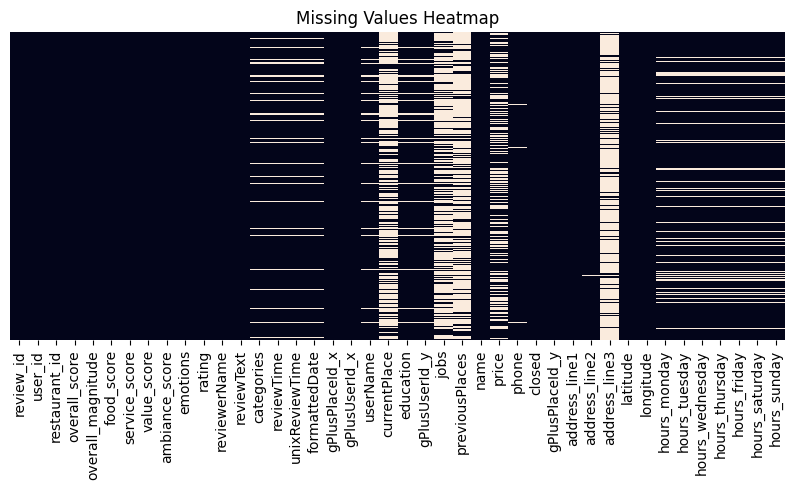

In [11]:
plt.figure(figsize=(10, 4))
sns.heatmap(df_merge.isnull(), cbar=False, yticklabels=False)
plt.title("Missing Values Heatmap")
plt.show()

The visualization above is a heatmap showing the distribution of missing values across the dataset. It was generated using `seaborn.heatmap()` on the result of `df_merge.isnull()`, which highlights the presence of null (missing) values for each column. In this heatmap, each white line represents a missing value in a specific row and column, while black areas indicate complete data.

From the heatmap, we can observe that:
- Some columns (like `address_line2`, business hour fields, and `jobs`) have significant portions of missing data, as shown by solid vertical bands of white.
- Other columns (like `review_id`, `user_id`, `rating`, and `reviewText`) are mostly complete, appearing fully black.

This visual summary is especially helpful for quickly identifying columns that might need to be dropped, filled, or handled carefully during data cleaning. It complements the numeric null count and provides an intuitive way to assess overall data quality before preprocessing.

In [12]:
# Create a copy to work on safely
df_clean = df_merge.copy()

In [13]:
cols_to_drop = [
    'address_line3', 'hours_monday', 'hours_tuesday', 'hours_wednesday',
    'hours_thursday', 'hours_friday', 'hours_saturday', 'hours_sunday', 'adress_line3',
    'phone', 'previousPlaces', 'jobs', 'currentPlace', 'usernames', 'gPlusPlaceId' # these last two are things we dont need due to user id
]
df_clean.drop(columns=[col for col in cols_to_drop if col in df_merge.columns], inplace=True)


A list of columns with excessive missing data or little analytical value (such as business hours, address line 3, phone, previous places, and duplicate identifiers like `gPlusPlaceId`) is compiled and removed from `df_clean`. This reduces noise in the dataset and improves overall quality for modeling.


In [14]:
#Fill missing values for categorical columns with "unknown"
df_clean["price"].fillna("unknown", inplace=True)
df_clean["education"].fillna("unknown", inplace=True)
df_clean["closed"].fillna(False, inplace=True)
df_clean["categories"].fillna("unknown", inplace=True) # we can try to chang this to nlp if we want idk



Several important categorical columns — including `price`, `education`, `closed`, and `categories` — are filled with the placeholder `"unknown"` or `False` for logical binary values like `closed`. This ensures consistency and avoids issues during encoding or grouping.


Missing values in score columns:
overall_score        0
overall_magnitude    0
food_score           0
service_score        0
value_score          0
ambiance_score       0
dtype: int64

Distribution statistics for score columns:
       overall_score  overall_magnitude    food_score  service_score  \
count   24780.000000       24780.000000  24780.000000   24780.000000   
mean        0.612060           0.264018      0.147209       0.081603   
std         0.441256           0.186645      0.185614       0.161163   
min        -0.994300           0.000000     -0.582994      -0.510941   
25%         0.492700           0.121000      0.000000       0.000000   
50%         0.792500           0.236000      0.100137       0.000000   
75%         0.914800           0.375000      0.300458       0.178795   
max         0.999200           1.000000      0.691480       0.571487   

        value_score  ambiance_score  
count  24780.000000    24780.000000  
mean       0.054699        0.051984  
std      

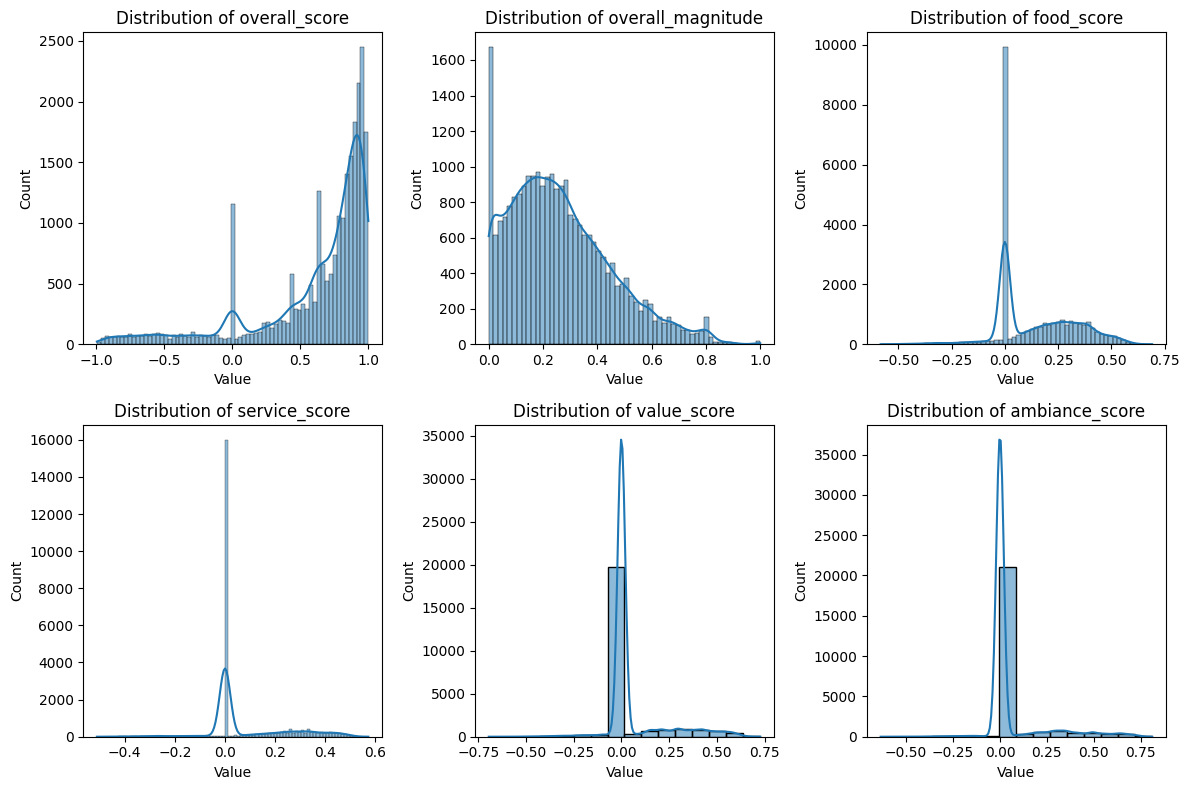

In [15]:
# Define the score columns
score_cols = [
    "overall_score", "overall_magnitude", "food_score",
    "service_score", "value_score", "ambiance_score"
]

# Check for missing values
print("Missing values in score columns:")
print(df_merge[score_cols].isna().sum())

# Analyze the distribution of each column
print("\nDistribution statistics for score columns:")
print(df_merge[score_cols].describe())

# Check the relationship between rating and overall_score
print("\nCorrelation between 'rating' and score columns:")
corr_cols = ["rating"] + score_cols
print(df_merge[corr_cols].corr()["rating"])

# Visualize the distribution
plt.figure(figsize=(12, 8))
for i, col in enumerate(score_cols):
    plt.subplot(2, 3, i+1)
    sns.histplot(df_merge[col].dropna(), kde=True)
    plt.title(f"Distribution of {col}")
    plt.xlabel("Value")
    plt.ylabel("Count")
plt.tight_layout()

Looking at the distributions, it's clear that the aspect-specific scores (food, service, value, and ambiance) have extreme concentrations of zeros—likely representing missing data rather than actual zero ratings. These features are too sparse to be reliably fixed or imputed.

In contrast, the overall_score and overall_magnitude features show much more meaningful distributions. The overall_score ranges from -1.0 to 1.0 with a positive skew (most values near 1.0), representing sentiment polarity where positive values indicate positive sentiment. The overall_magnitude ranges from 0.0 to 0.8 with a more normal distribution centered around 0.2-0.3, likely representing the intensity or confidence of the sentiment regardless of direction.

In [16]:
# Drop the specified columns from df_clean
columns_to_remove = ["food_score", "service_score", "value_score", "ambiance_score"]
df_clean = df_clean.drop(columns=columns_to_remove)

# Verify the result
print("Columns after removal:", df_clean.columns)

Columns after removal: Index(['review_id', 'user_id', 'restaurant_id', 'overall_score',
       'overall_magnitude', 'emotions', 'rating', 'reviewerName', 'reviewText',
       'categories', 'reviewTime', 'unixReviewTime', 'formattedDate',
       'gPlusPlaceId_x', 'gPlusUserId_x', 'userName', 'education',
       'gPlusUserId_y', 'name', 'price', 'closed', 'gPlusPlaceId_y',
       'address_line1', 'address_line2', 'latitude', 'longitude'],
      dtype='object')


Drop those columns as impossible to work with.

In [17]:
# Treat 0 as missing
df_clean.loc[df_clean["overall_score"] == 0, "overall_score"] = np.nan
# Fill missing with median (of non-zero values if preferred)
median_score = df_clean["overall_score"].median()
df_clean["overall_score"] = df_clean["overall_score"].fillna(median_score).clip(-1, 1)
# Normalize from [-1, 1] to [0, 1]
df_clean["overall_score"] = (df_clean["overall_score"] + 1) / 2

# Treat 0 as missing for overall_magnitude, then fill with median of non-zero values, and clip to [0, 1]
df_clean.loc[df_clean["overall_magnitude"] == 0, "overall_magnitude"] = np.nan
non_zero_magnitude = df_clean.loc[df_clean["overall_magnitude"] > 0, "overall_magnitude"]
median_magnitude = non_zero_magnitude.median() if not non_zero_magnitude.empty else 0.2
df_clean["overall_magnitude"] = df_clean["overall_magnitude"].fillna(median_magnitude).clip(0, 1)

In this dataset, a value of 0 in the score columns (e.g., overall_score, food_score, etc.) often indicated missing information rather than a true zero score. To account for this, we treated both explicit NaN values and zeros as missing. Instead of imputing with a default value like zero—which could introduce bias or noise—we filled these missing entries with the median of the non-zero values in each column. This approach preserves the distribution and minimizes the impact on downstream models by using representative, low-noise estimates.

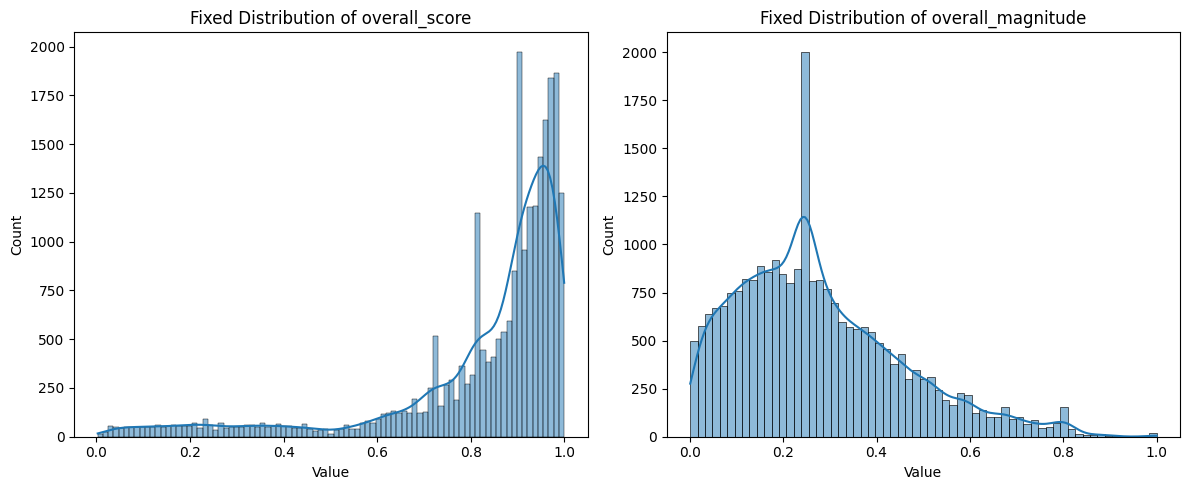

In [18]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df_clean["overall_score"], kde=True)
plt.title("Fixed Distribution of overall_score")
plt.xlabel("Value")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
sns.histplot(df_clean["overall_magnitude"], kde=True)
plt.title("Fixed Distribution of overall_magnitude")
plt.xlabel("Value")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

In [19]:
#Drop rows if critical text/tags are missing
df_clean = df_clean[df_clean["reviewText"].notna()]
df_clean = df_clean[df_clean["reviewText"].str.strip() != ""]
df_clean = df_clean[df_clean["rating"].notna()]
#Drop rows where timestamps are missing (critical for time-based modeling)
df_clean = df_clean[df_clean["reviewTime"].notna()]
df_clean = df_clean[df_clean["unixReviewTime"].notna()]
df_clean = df_clean[df_clean["formattedDate"].notna()]


Rows with missing or empty values in key review fields such as `reviewText`, `rating`, `reviewTime`, `unixReviewTime`, and `formattedDate` are dropped. These fields are essential for sentiment analysis, user behavior tracking, and time-based modeling. Retaining rows without this information would compromise the consistency of the dataset.


In [20]:
# Drop rows with missing place info (only 15 rows — safe)
df_clean = df_clean[df_clean["name"].notna()]
df_clean = df_clean[df_clean["gPlusPlaceId_y"].notna()]
df_clean = df_clean[df_clean["address_line1"].notna()]
df_clean = df_clean[df_clean["address_line2"].notna()]
df_clean = df_clean[df_clean["gPlusUserId_y"].notna()]
df_clean = df_clean[df_clean["gPlusUserId_x"].notna()]


# Drop rows with missing latitude/longitude (only 211 rows)
df_clean = df_clean[df_clean["latitude"].notna()]
df_clean = df_clean[df_clean["longitude"].notna()]

Rows missing basic restaurant identifiers such as `name`, `gPlusPlaceId_y`, or `address_line1` are dropped. Since only 15 rows are affected, this cleanup step is safe and ensures that every review is linked to a well-defined place.


Latitude and longitude are essential if the dataset is to be used for location-based recommendations or map visualizations. Only 211 rows are affected, so dropping them avoids introducing noise or nulls in spatial analysis.


In [21]:
# 4. Drop duplicates 
before = df_clean.shape[0]
df_clean.drop_duplicates(inplace=True)
after = df_clean.shape[0]
print(f"\n Removed {before - after} duplicate rows")


 Removed 0 duplicate rows


Finally, any duplicate rows are removed to ensure uniqueness in the dataset. The code also prints the number of duplicates removed by comparing the DataFrame shape before and after the operation.


In [22]:
#Final Check for Any Remaining Missing Values
missing = df_clean.isnull().sum()
print("Remaining missing values:\n", missing[missing > 0])


Remaining missing values:
 Series([], dtype: int64)


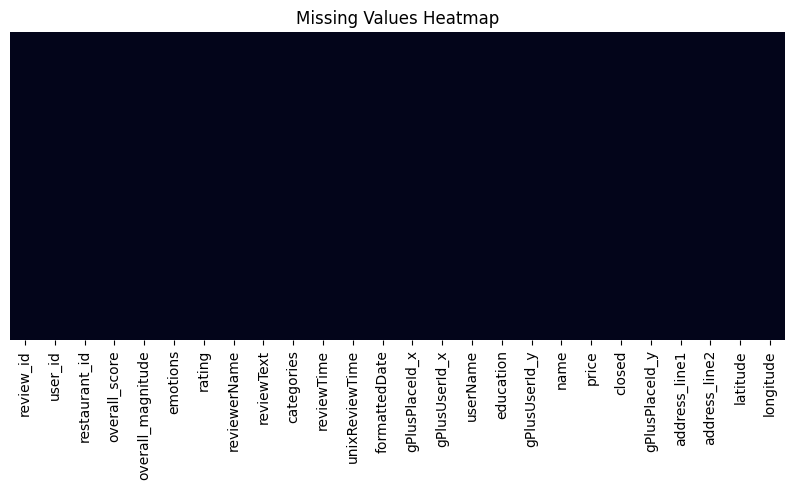

In [23]:
plt.figure(figsize=(10, 4))
sns.heatmap(df_clean.isnull(), cbar=False, yticklabels=False)
plt.title("Missing Values Heatmap")
plt.show()

no more missing values!! :)

In [24]:
df_clean.shape

(22929, 26)

In [25]:
# ---------- 1. Review the dataset ----------
print("\nColumns in clean dataset:\n", df_clean.columns.tolist())
print("\nData types and nulls:\n")
df_clean.info()


Columns in clean dataset:
 ['review_id', 'user_id', 'restaurant_id', 'overall_score', 'overall_magnitude', 'emotions', 'rating', 'reviewerName', 'reviewText', 'categories', 'reviewTime', 'unixReviewTime', 'formattedDate', 'gPlusPlaceId_x', 'gPlusUserId_x', 'userName', 'education', 'gPlusUserId_y', 'name', 'price', 'closed', 'gPlusPlaceId_y', 'address_line1', 'address_line2', 'latitude', 'longitude']

Data types and nulls:

<class 'pandas.core.frame.DataFrame'>
Index: 22929 entries, 0 to 24779
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   review_id          22929 non-null  object 
 1   user_id            22929 non-null  object 
 2   restaurant_id      22929 non-null  object 
 3   overall_score      22929 non-null  float64
 4   overall_magnitude  22929 non-null  float64
 5   emotions           22929 non-null  object 
 6   rating             22929 non-null  float64
 7   reviewerName       22929 non-nu

In [26]:
# Create the folder if it doesn't exist
clean_dir = "clean_dataset"
os.makedirs(clean_dir, exist_ok=True)

# Save the cleaned DataFrame
clean_path = os.path.join(clean_dir, "clean_restaurant_data.csv")
df_clean.to_csv(clean_path, index=False)

print(f"\nCleaned dataset saved to: {clean_path}")



Cleaned dataset saved to: clean_dataset/clean_restaurant_data.csv


Through a comprehensive data cleaning and preprocessing pipeline, we successfully transformed a raw, multi-source dataset into a clean and structured format suitable for analysis and recommendation modeling. We began by merging four separate datasets — reviews, sentiments, users, and places — using unique identifiers such as `user_id` and `restaurant_id` to consolidate review content with metadata about users and restaurants. 

Next, we conducted detailed missing value analysis using both statistical summaries and visual heatmaps, which guided our strategy for handling incomplete data. We removed irrelevant or excessively incomplete columns, filled missing values in categorical fields (like `price` and `education`) with `"unknown"`, and replaced missing numeric sentiment scores with `0` to represent neutrality. We also filtered out reviews missing critical text, timestamps, or geographic data, and eliminated duplicates to ensure the integrity of the dataset.

The resulting dataset is clean, complete, and ready for exploratory data analysis, feature engineering, and the development of a personalized restaurant recommendation system.

### Step 4: Basic exploration



In [27]:
print("\n=== Dataset Overview ===")
print(df_clean.shape)
print(df_clean.columns)
print(df_clean.dtypes)
print(df_clean.describe(include='all'))


=== Dataset Overview ===
(22929, 26)
Index(['review_id', 'user_id', 'restaurant_id', 'overall_score',
       'overall_magnitude', 'emotions', 'rating', 'reviewerName', 'reviewText',
       'categories', 'reviewTime', 'unixReviewTime', 'formattedDate',
       'gPlusPlaceId_x', 'gPlusUserId_x', 'userName', 'education',
       'gPlusUserId_y', 'name', 'price', 'closed', 'gPlusPlaceId_y',
       'address_line1', 'address_line2', 'latitude', 'longitude'],
      dtype='object')
review_id             object
user_id               object
restaurant_id         object
overall_score        float64
overall_magnitude    float64
emotions              object
rating               float64
reviewerName          object
reviewText            object
categories            object
reviewTime            object
unixReviewTime       float64
formattedDate         object
gPlusPlaceId_x        object
gPlusUserId_x         object
userName              object
education             object
gPlusUserId_y         object


=== Basic Stats: Ratings ===
count    22929.000000
mean         4.118322
std          1.019908
min          0.000000
25%          4.000000
50%          4.000000
75%          5.000000
max          5.000000
Name: rating, dtype: float64


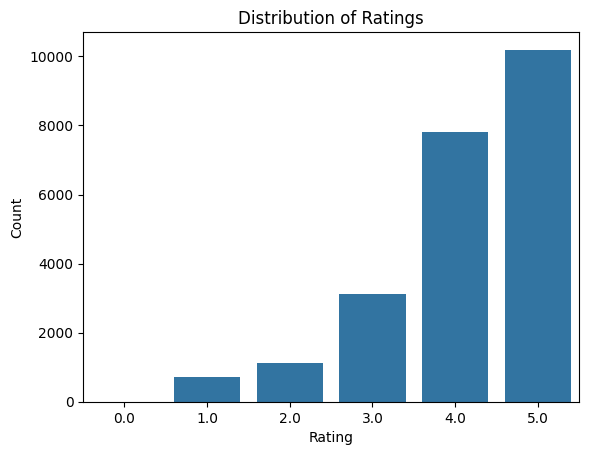

In [28]:
print("=== Basic Stats: Ratings ===")
print(df_clean['rating'].describe())
sns.countplot(x='rating', data=df_clean)
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()



=== Sentiment Score Distributions ===


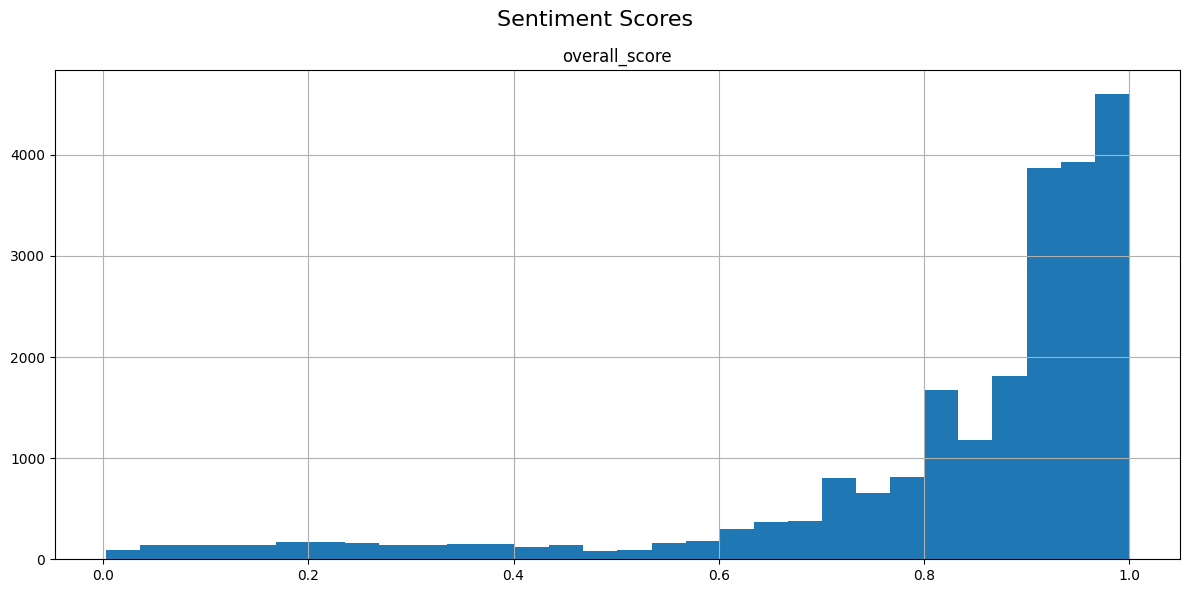

In [29]:
### Step 3: Sentiment Scores
sentiment_scores = ['overall_score']
print("\n=== Sentiment Score Distributions ===")
df_clean[sentiment_scores].hist(figsize=(12, 6), bins=30)
plt.suptitle("Sentiment Scores", fontsize=16)
plt.tight_layout()
plt.show()

In [30]:
# Sentiment Subscores
sentiment_cols = ['overall_score']
print("\n=== Basic Stats: Sentiment Scores ===")
print(df_clean[sentiment_cols].describe())


=== Basic Stats: Sentiment Scores ===
       overall_score
count   22929.000000
mean        0.825807
std         0.210977
min         0.002850
25%         0.796350
50%         0.903500
75%         0.958300
max         0.999600


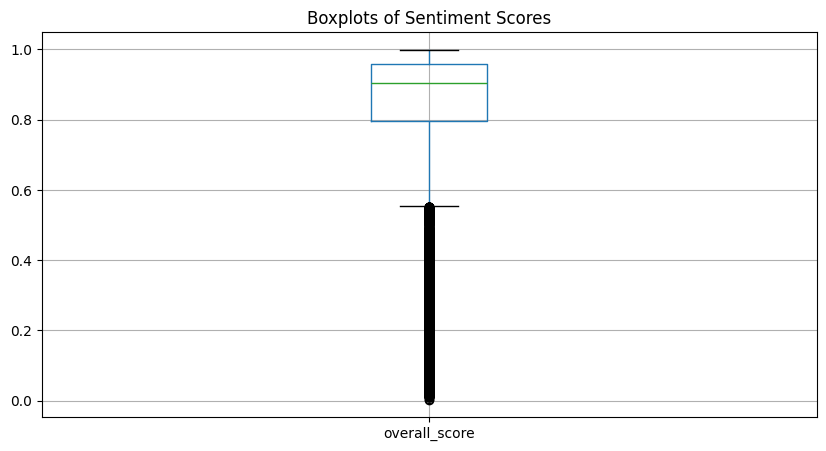

In [31]:

df_clean[sentiment_cols].boxplot(figsize=(10,5))
plt.title("Boxplots of Sentiment Scores")
plt.show()


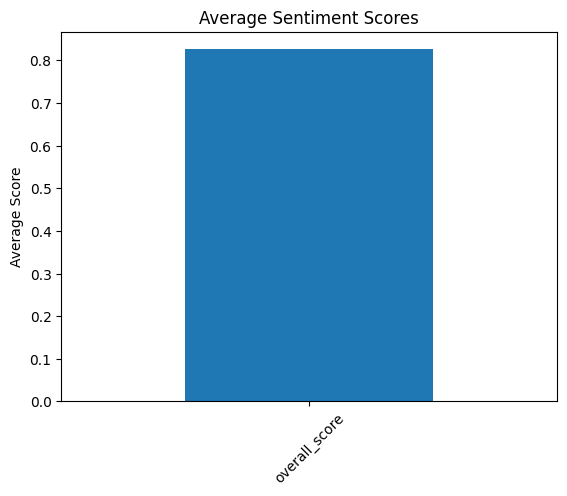

In [32]:
df_clean[sentiment_cols].mean().plot(kind='bar')
plt.title("Average Sentiment Scores")
plt.ylabel("Average Score")
plt.xticks(rotation=45)
plt.show()

In [33]:
# 5. Interaction Matrix & Sparsity
num_users = df_clean['user_id'].nunique()
num_items = df_clean['restaurant_id'].nunique()
total_ratings = df_clean.shape[0]
sparsity = 1 - (total_ratings / (num_users * num_items))
print(f"Users: {num_users}, Restaurants: {num_items}, Total Ratings: {total_ratings}")
print(f"Sparsity of interaction matrix: {sparsity:.2%}")

Users: 6105, Restaurants: 9797, Total Ratings: 22929
Sparsity of interaction matrix: 99.96%


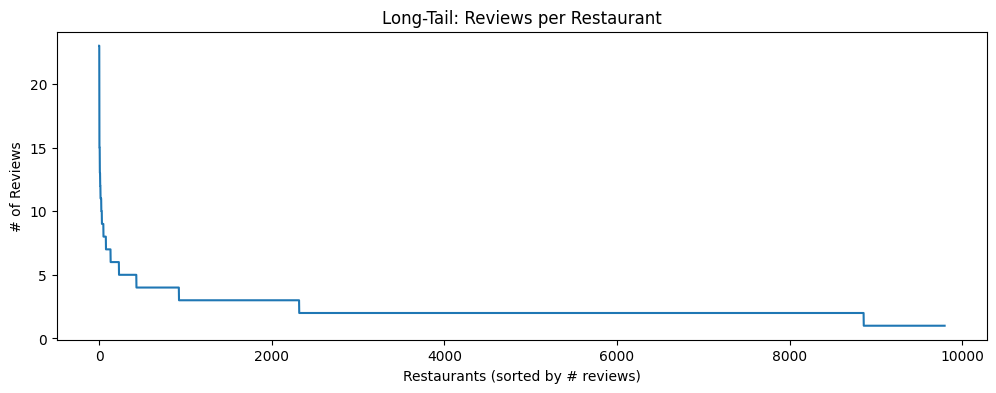

In [34]:
# Count number of reviews per restaurant
rest_freq = df_clean["restaurant_id"].value_counts()

plt.figure(figsize=(12,4))
sns.lineplot(data=rest_freq.sort_values(ascending=False).reset_index(drop=True))
plt.title("Long-Tail: Reviews per Restaurant")
plt.xlabel("Restaurants (sorted by # reviews)")
plt.ylabel("# of Reviews")
plt.show()



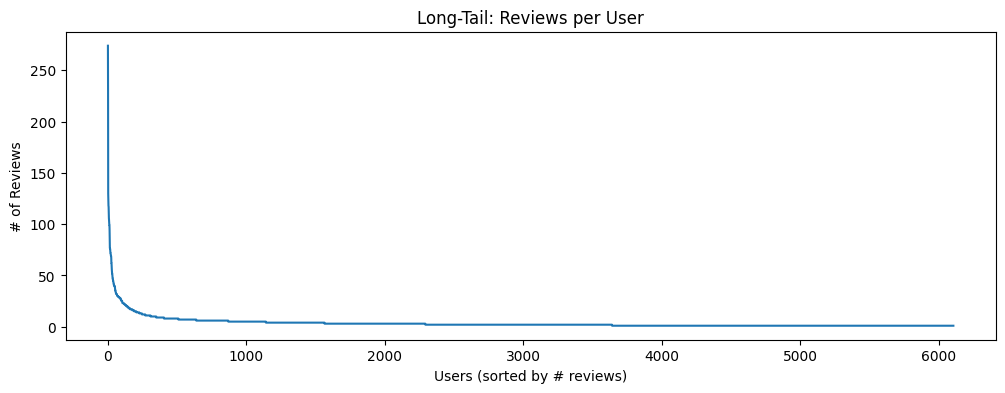

In [35]:
# Count number of reviews per user
user_freq = df_clean["user_id"].value_counts()

# Plot long-tail distribution
plt.figure(figsize=(12, 4))
sns.lineplot(data=user_freq.sort_values(ascending=False).reset_index(drop=True))
plt.title("Long-Tail: Reviews per User")
plt.xlabel("Users (sorted by # reviews)")
plt.ylabel("# of Reviews")
plt.show()

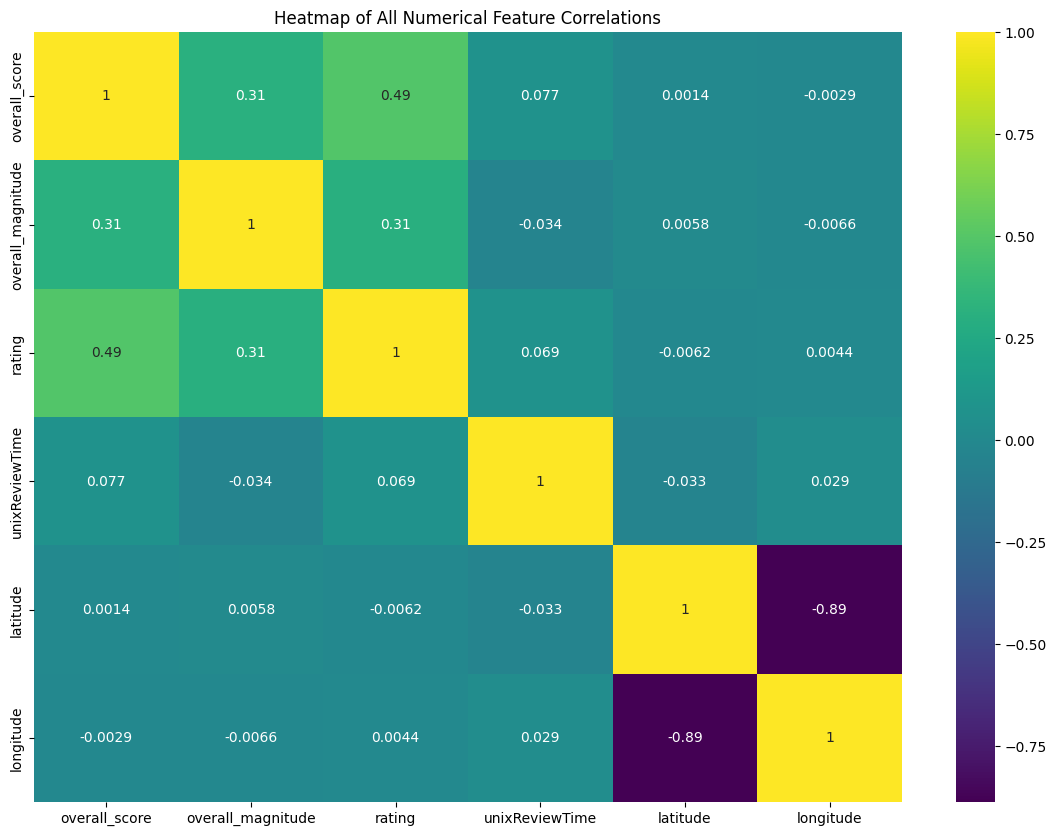

In [36]:
correlation = df_clean.select_dtypes(include=['float64', 'int64']).corr()
plt.figure(figsize=(14,10))
sns.heatmap(correlation, annot=True, cmap='viridis')
plt.title("Heatmap of All Numerical Feature Correlations")
plt.show()

### Step 5: Item Metadata Exploration


In [37]:
import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'notebook'  # or 'iframe' or 'browser'


In [38]:
# Clean out invalid coordinates
map_df = df_clean.dropna(subset=['latitude', 'longitude'])
map_df = map_df[(map_df['latitude'] != 0) & (map_df['longitude'] != 0)]
print("Total rows in df_clean:", len(df_clean))

valid_coords = df_clean.dropna(subset=['latitude', 'longitude'])
valid_coords = valid_coords[(valid_coords['latitude'] != 0) & (valid_coords['longitude'] != 0)]
print("Valid lat/lon rows:", len(valid_coords))
print(valid_coords[['name', 'latitude', 'longitude']].head())

# Now plot the interactive map
px.scatter_mapbox(
    valid_coords,
    lat="latitude",
    lon="longitude",
    hover_name="name",
    color="rating",
    zoom=1,
    center=dict(lat=0, lon=0),  # Centered on world
    mapbox_style="carto-positron",
    title="Global Map of Restaurants"
).show()

Total rows in df_clean: 22929
Valid lat/lon rows: 22929
                    name   latitude   longitude
0              La Corona  40.175064 -122.242574
1  Glass Doctor Triangle  35.894768  -78.745868
2    The Davenport Hotel  47.656892 -117.424184
3         Rocking V Cafe  37.047998 -112.530493
4           Trader Joe's  40.778503  -73.982249


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [39]:
print("=== Categories ===")
print(df_clean['categories'].value_counts().head(10))

=== Categories ===
categories
American Restaurant                                          559
Mexican Restaurant; Latin American Restaurant                416
Restaurant                                                   390
Pizza Restaurant; European Restaurant; Italian Restaurant    346
Hotel                                                        308
Seafood Restaurant                                           271
Chinese Restaurant; Asian Restaurant                         266
Italian Restaurant; European Restaurant                      255
Bar                                                          254
Coffee Shop                                                  244
Name: count, dtype: int64


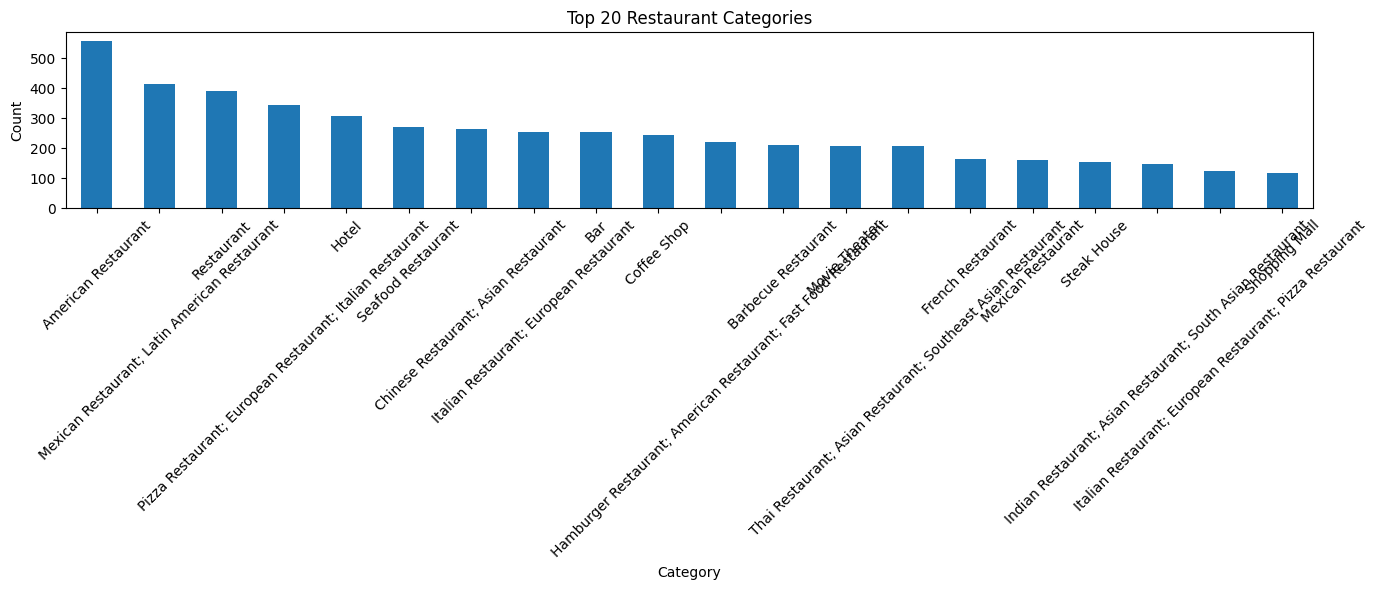

In [40]:
plt.figure(figsize=(14, 6))
df_clean['categories'].value_counts().head(20).plot(kind='bar')
plt.title("Top 20 Restaurant Categories")
plt.xlabel("Category")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Step 6: Contextual Information

In [41]:
df_clean['formattedDate'] = pd.to_datetime(df_clean['formattedDate'], errors='coerce')
df_clean['year'] = df_clean['formattedDate'].dt.year
df_clean['month'] = df_clean['formattedDate'].dt.month
df_clean['weekday'] = df_clean['formattedDate'].dt.day_name()

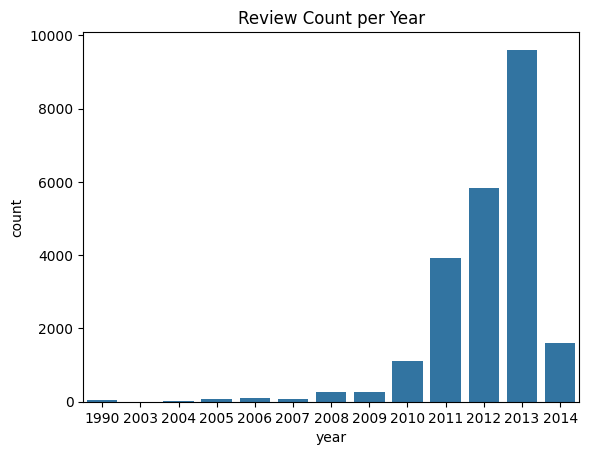

In [42]:
sns.countplot(x='year', data=df_clean)
plt.title("Review Count per Year")
plt.show()

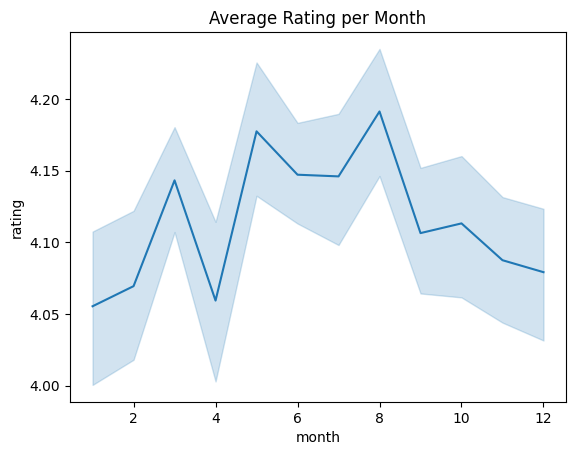

In [43]:
df_clean['month'] = df_clean['formattedDate'].dt.month

sns.lineplot(x='month', y='rating', data=df_clean)
plt.title("Average Rating per Month")
plt.show()

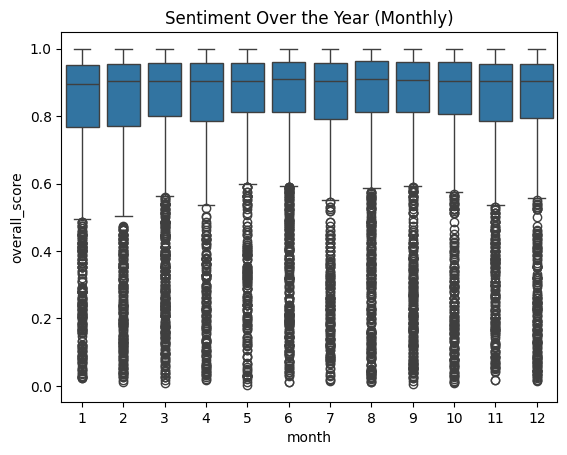

In [44]:
sns.boxplot(x='month', y='overall_score', data=df_clean)
plt.title("Sentiment Over the Year (Monthly)")
plt.show()

### Step 7: Ratings Data Analysis


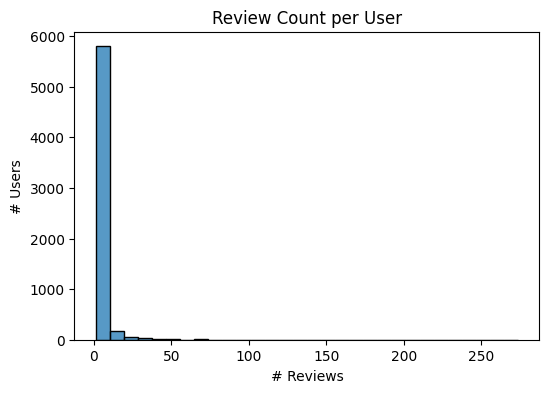

In [45]:
user_freq = df_clean['user_id'].value_counts()
plt.figure(figsize=(6,4))
sns.histplot(user_freq, bins=30)
plt.title("Review Count per User")
plt.xlabel("# Reviews")
plt.ylabel("# Users")
plt.show()

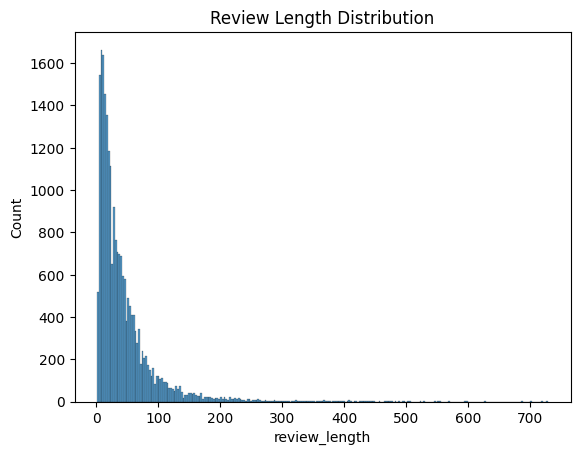

In [47]:
# Review Text Stats
df_clean['review_length'] = df_clean['reviewText'].apply(lambda x: len(str(x).split()))
sns.histplot(df_clean['review_length'])
plt.title("Review Length Distribution")
plt.show()

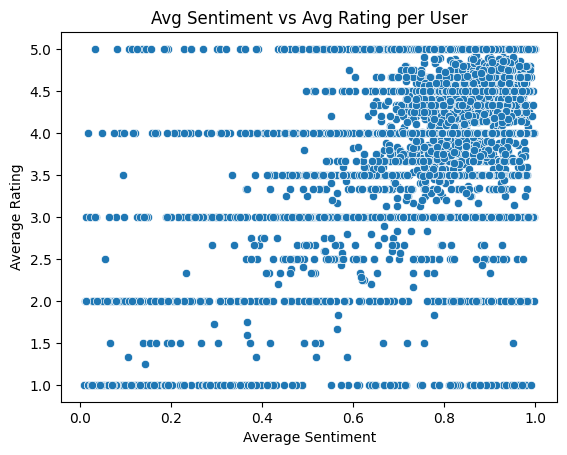

In [48]:
# Average sentiment vs. average rating per user
user_sentiment_rating = df_clean.groupby('user_id')[['rating', 'overall_score']].mean()
sns.scatterplot(data=user_sentiment_rating, x='overall_score', y='rating')
plt.title("Avg Sentiment vs Avg Rating per User")
plt.xlabel("Average Sentiment")
plt.ylabel("Average Rating")
plt.show()

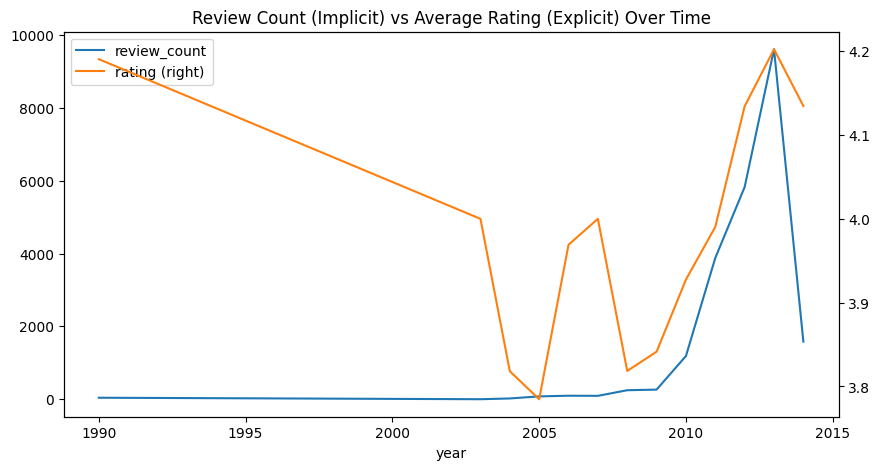

In [49]:
df_clean['review_date'] = pd.to_datetime(df_clean['reviewTime'], errors='coerce')
df_clean['year'] = df_clean['review_date'].dt.year

# Count of reviews (implicit) vs average rating (explicit)
reviews_per_year = df_clean.groupby('year').agg({
    'review_id': 'count',
    'rating': 'mean'
}).rename(columns={'review_id': 'review_count'})

reviews_per_year.plot(secondary_y='rating', figsize=(10,5), title="Review Count (Implicit) vs Average Rating (Explicit) Over Time")
plt.show()

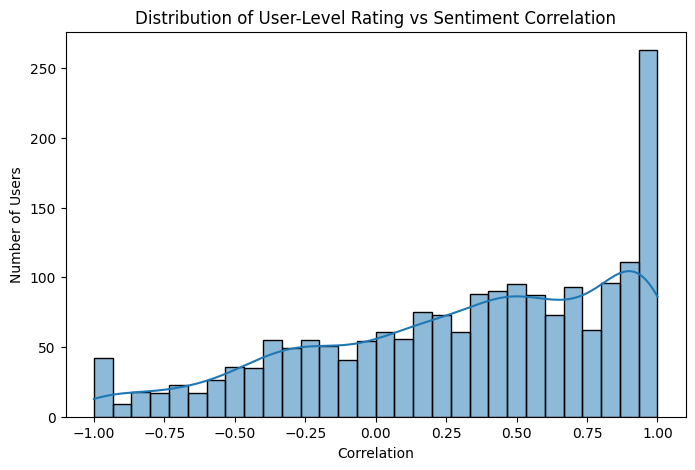

In [50]:
# Group reviews per user and compute correlation between rating and sentiment
user_corrs = []

for user_id, group in df_clean.groupby('user_id'):
    if group.shape[0] >= 3:  # only meaningful if they have 3+ reviews
        corr = group[['rating', 'overall_score']].corr().iloc[0, 1]
        user_corrs.append({'user_id': user_id, 'rating_sentiment_corr': corr})

user_corr_df = pd.DataFrame(user_corrs)

# Drop NaNs (users with constant scores will have NaN corr)
user_corr_df.dropna(inplace=True)

# Plot distribution
plt.figure(figsize=(8,5))
sns.histplot(user_corr_df['rating_sentiment_corr'], bins=30, kde=True)
plt.title("Distribution of User-Level Rating vs Sentiment Correlation")
plt.xlabel("Correlation")
plt.ylabel("Number of Users")
plt.show()

In [51]:
print("Top Reviewers:")
print(df_clean['user_id'].value_counts().head())

Top Reviewers:
user_id
100831647722887221013    274
100014808696256719518    230
100129788481293638112    130
100774493396272765333    124
100997035942150556481    118
Name: count, dtype: int64


In [52]:
most_reviewed = df_clean['restaurant_id'].value_counts().head().reset_index()
most_reviewed.columns = ['restaurant_id', 'count']

most_reviewed_named = most_reviewed.merge(df_clean[['restaurant_id', 'name']].drop_duplicates(), on='restaurant_id', how='left')
display(most_reviewed_named[['name', 'count']])

name  count
0  Katz's Delicatessen     23
1       Borough Market     23
2          Ike's Place     18
3      Voodoo Doughnut     15
4     The Slanted Door     15

In [53]:
# Cold start check
print(f"Cold-start users (<2 reviews): {sum(user_freq < 2)}")
print(f"Cold-start restaurants (<2 reviews): {sum(rest_freq < 2)}")


Cold-start users (<2 reviews): 2465
Cold-start restaurants (<2 reviews): 939


### Step 8: Sentiment & Emotion Analysis

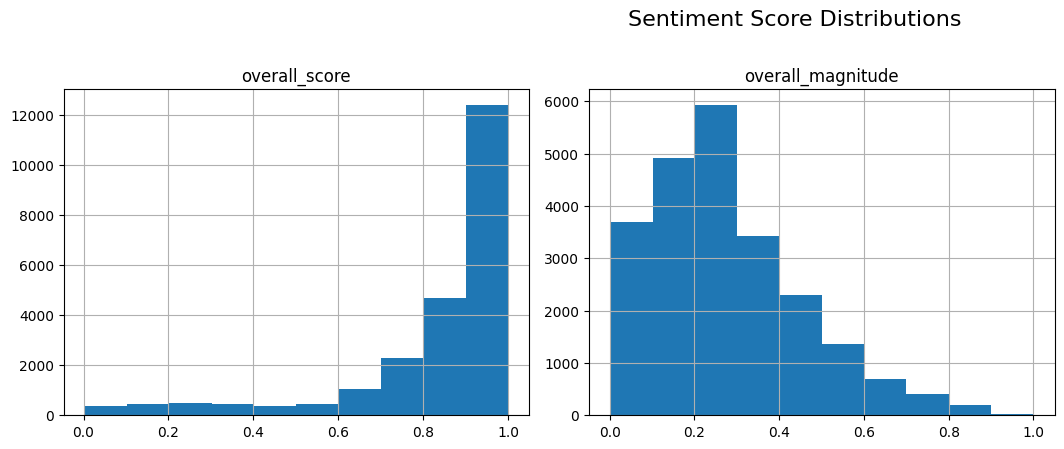

In [55]:
# 7.1 Score Distributions
sentiment_scores = ['overall_score', "overall_magnitude"]
df_clean[sentiment_scores].hist(figsize=(16, 8), layout=(2, 3))
plt.suptitle("Sentiment Score Distributions", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

In [ ]:
from collections import Counter

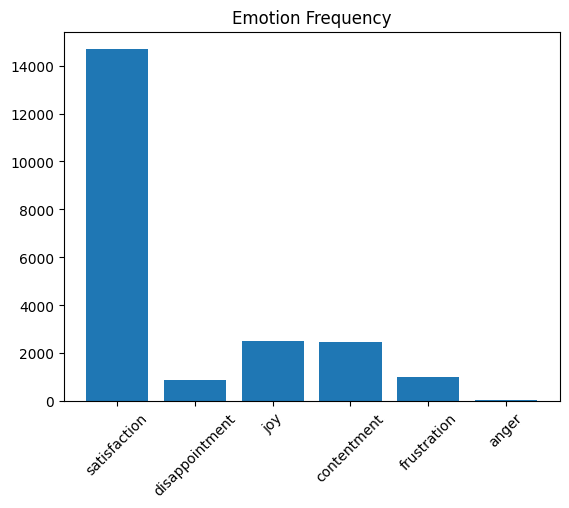

In [56]:
emotion_series = df_clean['emotions'].dropna().apply(ast.literal_eval)
emotion_flat = Counter([e for sub in emotion_series for e in sub])
plt.bar(emotion_flat.keys(), emotion_flat.values())
plt.title("Emotion Frequency")
plt.xticks(rotation=45)
plt.show()


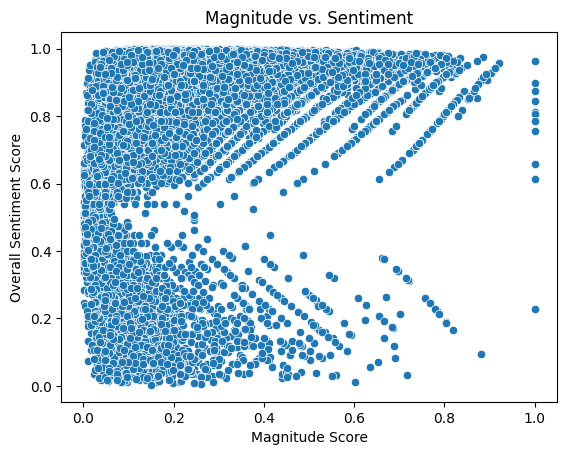

In [59]:
sns.scatterplot(
    data=df_clean.dropna(subset=['overall_magnitude', 'overall_score']),
    x='overall_magnitude',
    y='overall_score'
)
plt.title("Magnitude vs. Sentiment")
plt.xlabel("Magnitude Score")
plt.ylabel("Overall Sentiment Score")
plt.show()

This scatter plot reveals a concentration of reviews with low magnitude scores spread across the full range of sentiment values, suggesting that many reviews are short or neutral yet still receive sentiment scores—possibly due to imputation or limited text content. The distinct diagonal bands and clustering at sentiment score 1.0 indicate quantization or rounding in the scoring process, possibly from a model or discretized labels. The lack of points in the high-magnitude, low-sentiment region aligns with the idea that highly emotional reviews tend to skew positive in this dataset. Overall, the pattern highlights a strong bias toward positive sentiment and suggests careful handling of low-magnitude entries to avoid inflating sentiment predictions.

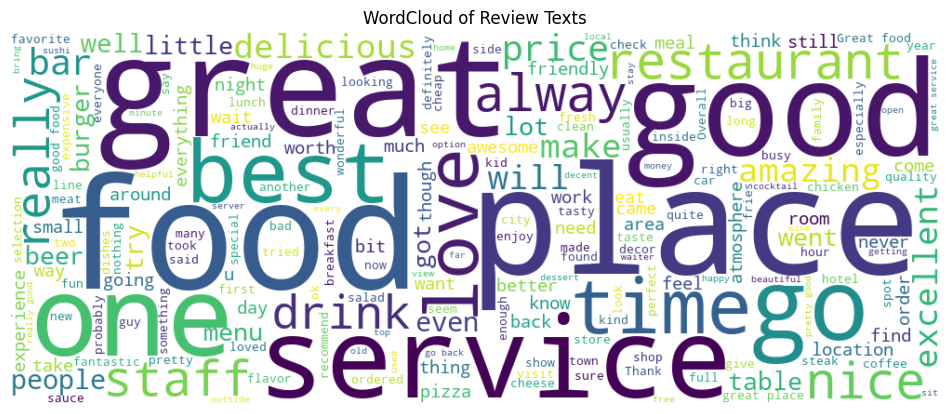

In [60]:
text_combined = " ".join(df_clean['reviewText'].dropna().astype(str).tolist())
wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', width=1000, height=400).generate(text_combined)
plt.figure(figsize=(12, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud of Review Texts")
plt.show()

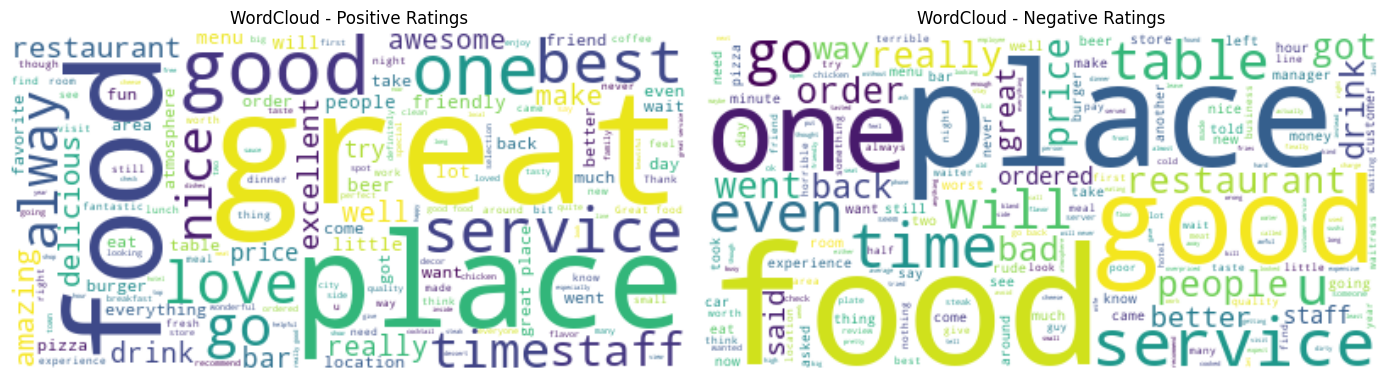

In [61]:
from wordcloud import WordCloud, STOPWORDS

positive_text = " ".join(df_clean[df_clean['rating'] >= 4]['reviewText'].dropna().astype(str))
negative_text = " ".join(df_clean[df_clean['rating'] <= 2]['reviewText'].dropna().astype(str))

plt.figure(figsize=(14,6))
plt.subplot(1, 2, 1)
wordcloud_pos = WordCloud(stopwords=STOPWORDS, background_color='white').generate(positive_text)
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud - Positive Ratings")

plt.subplot(1, 2, 2)
wordcloud_neg = WordCloud(stopwords=STOPWORDS, background_color='white').generate(negative_text)
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud - Negative Ratings")

plt.tight_layout()
plt.show()


These side-by-side word clouds highlight contrasting themes between positive and negative reviews. While both emphasize common topics like food, place, and service, the positive reviews (left) are filled with affirming words such as great, love, amazing, and excellent, expressing satisfaction. In contrast, the negative reviews (right) often reflect disappointment or conflict through negation and complaint-related terms like never, went, even, back, and said, which suggest negative experiences, unmet expectations, or recounting of bad service. The presence ofthe world good good be explain by the negation "not good". This linguistic shift—moving from praise to criticism, from description to confrontation—clearly captures the emotional tone embedded in customer feedback. 

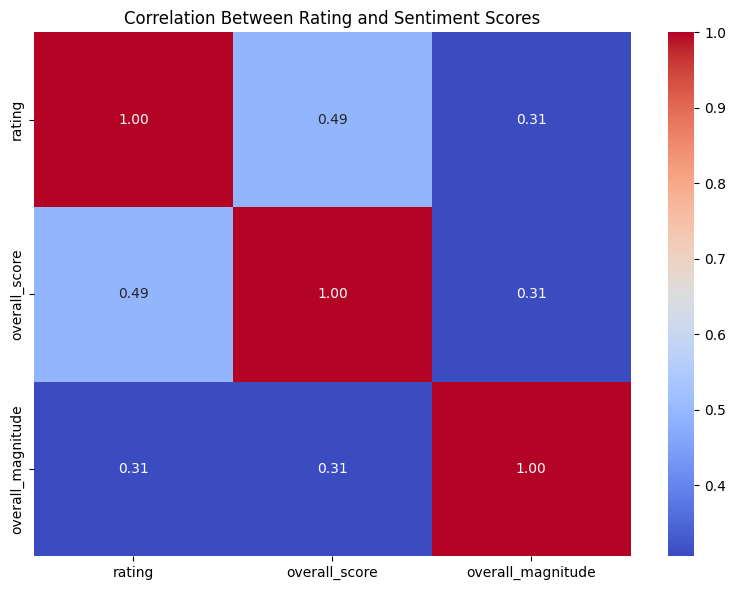

In [64]:
# Ensure rating is numeric
df_clean['rating'] = pd.to_numeric(df_clean['rating'], errors='coerce')

# Define sentiment score columns
sentiment_scores = ['overall_score', 'overall_magnitude']

# Select relevant columns
correlation_matrix = df_clean[['rating'] + sentiment_scores].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Between Rating and Sentiment Scores")
plt.tight_layout()
plt.show()

### Step 9: Dimensionality Reduction and Feature Insights

Missing values in numeric columns:
overall_score        0
overall_magnitude    0
rating               0
unixReviewTime       0
latitude             0
longitude            0
dtype: int64
Shape after dropping missing values: (22929, 31)

Variance Explained by Principal Components:
Principal Component  Explained Variance (%)  Cumulative Variance (%)
                PC1               31.484326                31.484326
                PC2               29.189564                60.673890
                PC3               16.918473                77.592363
                PC4               12.040361                89.632724
                PC5                8.477983                98.110706
                PC6                1.889294               100.000000

Feature Loadings (Contribution to Principal Components):
                        PC1       PC2       PC3       PC4       PC5       PC6
overall_score     -0.009065  0.611263  0.052444 -0.345339  0.710117  0.000255
overall_magnitude  0.00

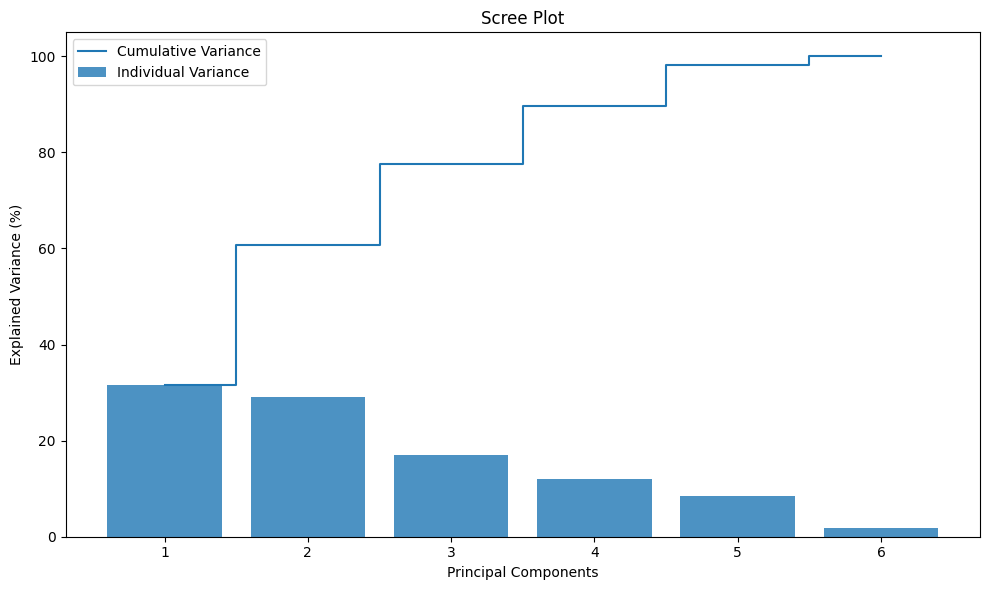

<Figure size 1000x800 with 0 Axes>

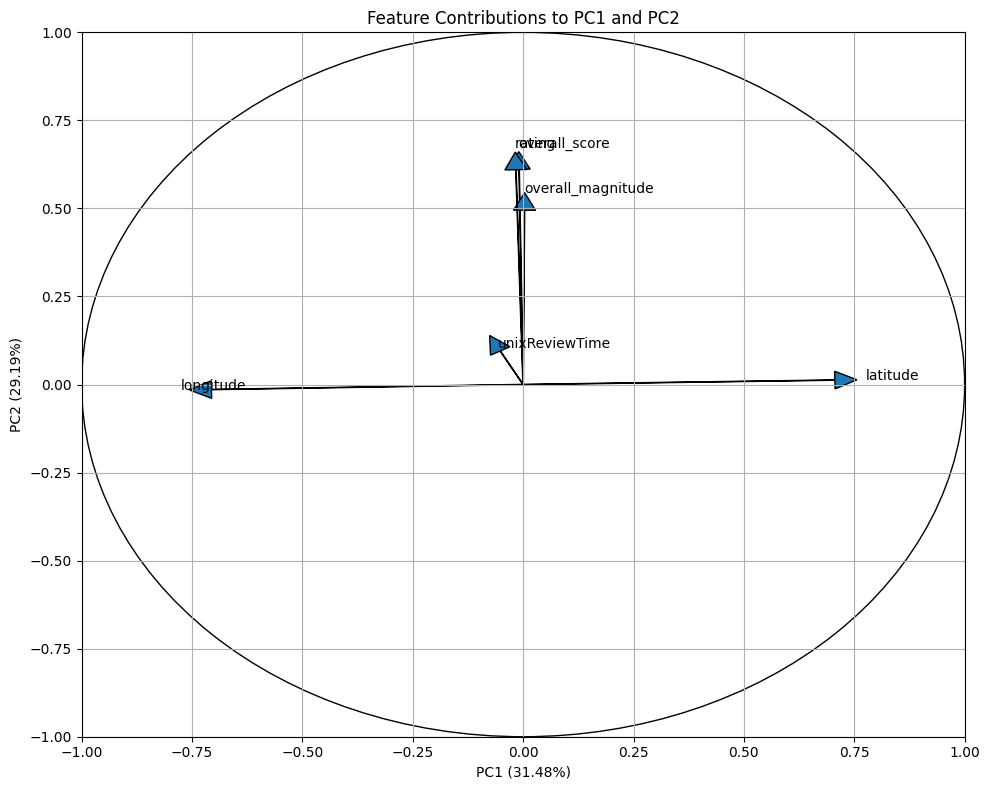

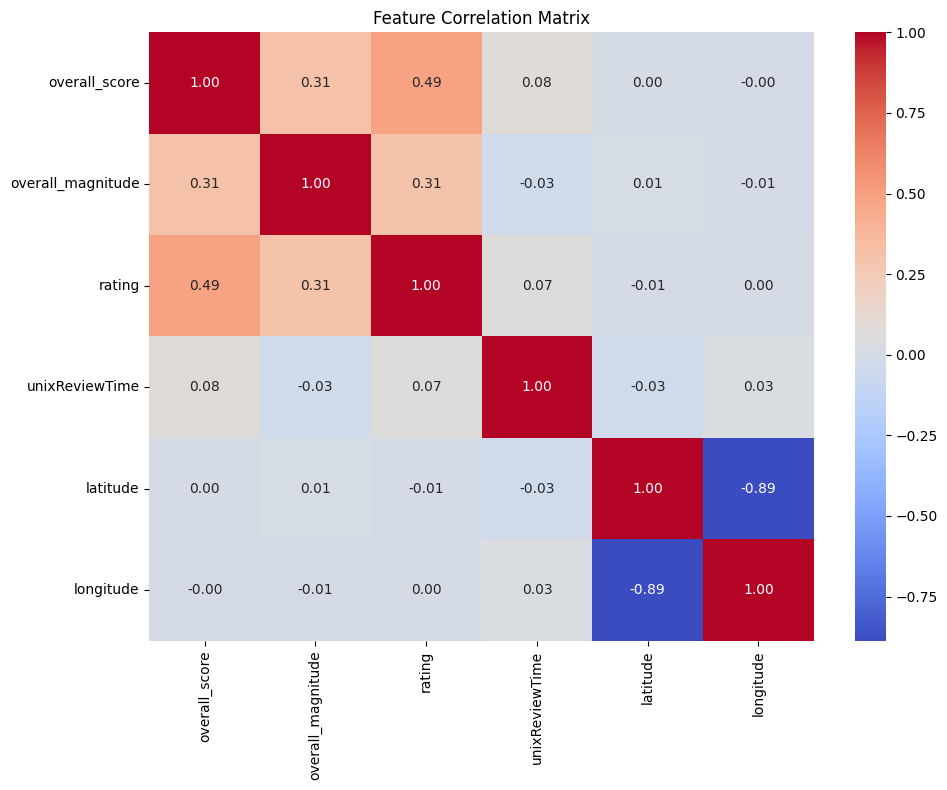

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset


# Extract only numeric columns for PCA
numeric_columns = ['overall_score', 'overall_magnitude', 'rating', 
                   'unixReviewTime', 'latitude', 'longitude']

# Check for missing values
print("Missing values in numeric columns:")
print(df_clean[numeric_columns].isnull().sum())

# Drop rows with missing values in numeric columns
df_numeric = df_clean[numeric_columns].dropna()
print(f"Shape after dropping missing values: {df_clean.shape}")

# Standardize the data (important for PCA)
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_numeric)

# Apply PCA
pca = PCA()
pca_result = pca.fit_transform(df_scaled)

# Create a DataFrame with PCA results
pca_df = pd.DataFrame(
    data=pca_result,
    columns=[f'PC{i+1}' for i in range(len(numeric_columns))]
)

# Calculate explained variance and cumulative variance
explained_variance = pca.explained_variance_ratio_ * 100
cumulative_variance = np.cumsum(explained_variance)

# Display variance explained by each principal component
variance_df = pd.DataFrame({
    'Principal Component': [f'PC{i+1}' for i in range(len(numeric_columns))],
    'Explained Variance (%)': explained_variance,
    'Cumulative Variance (%)': cumulative_variance
})
print("\nVariance Explained by Principal Components:")
print(variance_df.to_string(index=False))

# Visualize explained variance
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(numeric_columns) + 1), explained_variance, alpha=0.8, label='Individual Variance')
plt.step(range(1, len(numeric_columns) + 1), cumulative_variance, where='mid', label='Cumulative Variance')
plt.ylabel('Explained Variance (%)')
plt.xlabel('Principal Components')
plt.title('Scree Plot')
plt.xticks(range(1, len(numeric_columns) + 1))
plt.legend()
plt.tight_layout()

# Visualize feature contributions to principal components
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(len(numeric_columns))],
    index=numeric_columns
)

# Show loadings
print("\nFeature Loadings (Contribution to Principal Components):")
print(loadings)

# Visualize feature loadings for top 2 principal components
plt.figure(figsize=(10, 8))
loading_matrix = loadings.iloc[:, :2].values
features = loadings.index
plt.figure(figsize=(10, 8))
for i, feature in enumerate(features):
    plt.arrow(0, 0, loading_matrix[i, 0], loading_matrix[i, 1], head_width=0.05, head_length=0.05)
    plt.text(loading_matrix[i, 0] * 1.1, loading_matrix[i, 1] * 1.1, feature)

plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.xlabel(f'PC1 ({explained_variance[0]:.2f}%)')
plt.ylabel(f'PC2 ({explained_variance[1]:.2f}%)')
plt.grid()
plt.title('Feature Contributions to PC1 and PC2')
circle = plt.Circle((0, 0), 1, fill=False)
plt.gca().add_patch(circle)
plt.tight_layout()

# Correlation heatmap of features
plt.figure(figsize=(10, 8))
sns.heatmap(df_numeric.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.tight_layout()

print("\nPCA analysis completed and visualizations saved.")

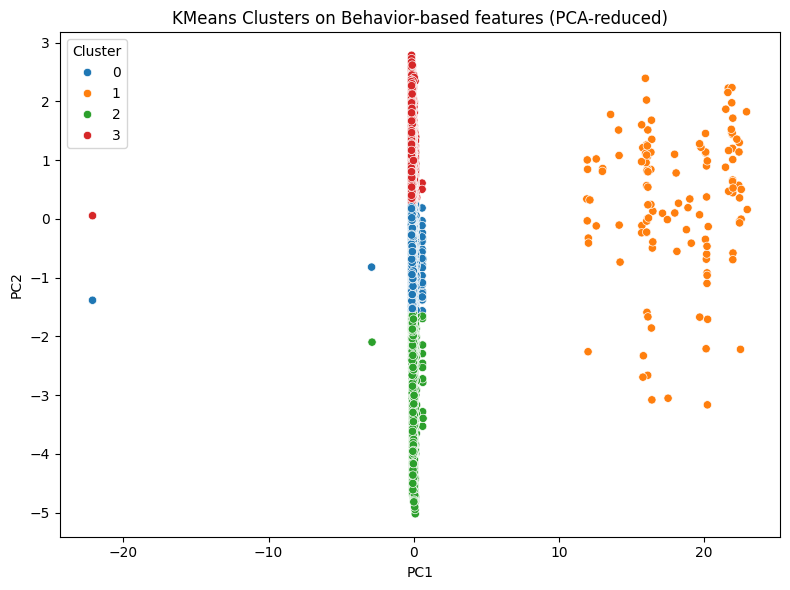

In [75]:
# Use 2D PCA for clustering
pca_2d = PCA(n_components=2)
sentiment_pca_2d = pca_2d.fit_transform(df_scaled)

# KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(sentiment_pca_2d)

# Visualize clusters
pca_df = pd.DataFrame(sentiment_pca_2d, columns=['PC1', 'PC2'])
pca_df['Cluster'] = clusters

plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', palette='tab10')
plt.title("KMeans Clusters on Behavior-based features (PCA-reduced)")
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

sentiment_features = df_clean[['overall_score', 'food_score', 'service_score', 'value_score', 'ambiance_score']].dropna()
scaler = StandardScaler()
sentiment_scaled = scaler.fit_transform(sentiment_features)
pca = PCA()
pca_result = pca.fit(sentiment_scaled)

used_feature_names = sentiment_features.columns[:pca.components_.shape[1]]
loadings = pd.DataFrame(pca.components_.T,
                        columns=[f'PC{i+1}' for i in range(len(pca.explained_variance_ratio_))],
                        index=used_feature_names)

print("Feature Loadings for PCA:")
print(loadings)

Feature Loadings for PCA:
                     PC1       PC2       PC3       PC4       PC5
overall_score   0.556973  0.079101 -0.165289  0.079665  0.806137
food_score      0.507409 -0.093112 -0.149090  0.717932 -0.442958
service_score   0.479352 -0.012969 -0.457867 -0.656978 -0.358875
value_score     0.317736  0.717433  0.589764 -0.106804 -0.158447
ambiance_score  0.318720 -0.685708  0.626888 -0.187618 -0.005848


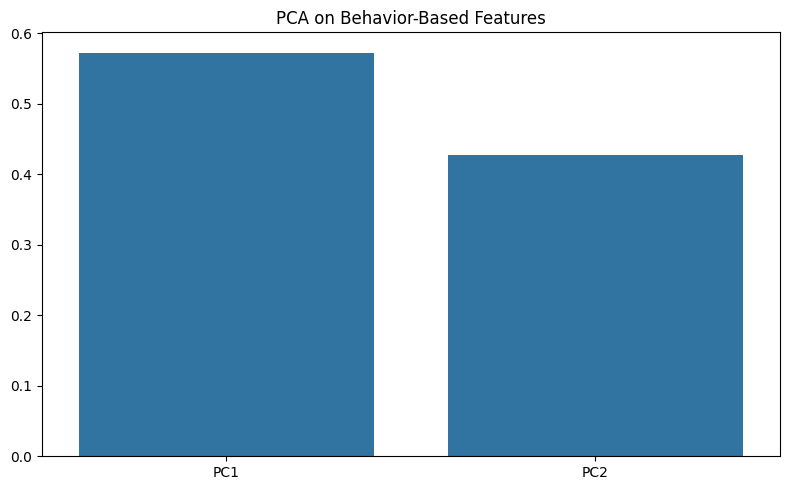

In [66]:
# Plot explained behavior by PC
behavior_features = df_clean[['rating', 'review_length']].dropna()

scaler = StandardScaler()
behavior_scaled = scaler.fit_transform(behavior_features)

pca = PCA()
pca_result = pca.fit(behavior_scaled)

# Plot explained variance
plt.figure(figsize=(8, 5))
sns.barplot(x=[f'PC{i+1}' for i in range(len(pca.explained_variance_ratio_))],
            y=pca.explained_variance_ratio_)
plt.title("PCA on Behavior-Based Features")
plt.tight_layout()
plt.show()

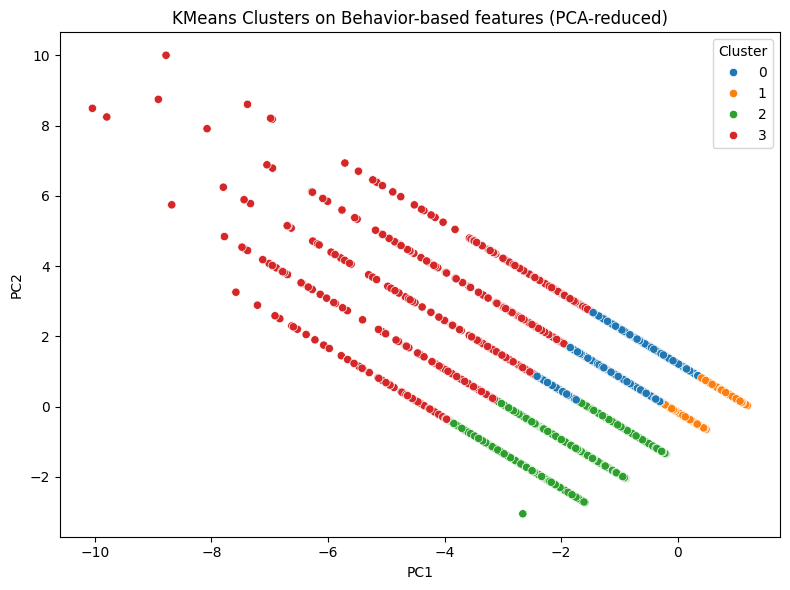

In [67]:
# Use 2D PCA for clustering
pca_2d = PCA(n_components=2)
behavior_pca_2d = pca_2d.fit_transform(behavior_scaled)

# KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(behavior_pca_2d)

# Visualize clusters
pca_df = pd.DataFrame(behavior_pca_2d, columns=['PC1', 'PC2'])
pca_df['Cluster'] = clusters

plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', palette='tab10')
plt.title("KMeans Clusters on Behavior-based features (PCA-reduced)")
plt.tight_layout()
plt.show()

In [68]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

behavior_features = df_clean[['rating', 'review_length']].dropna()
scaler = StandardScaler()
sentiment_scaled = scaler.fit_transform(behavior_features)
pca = PCA()
pca_result = pca.fit(sentiment_scaled)

used_feature_names = behavior_features.columns[:pca.components_.shape[1]]
loadings = pd.DataFrame(pca.components_.T,
                        columns=[f'PC{i+1}' for i in range(len(pca.explained_variance_ratio_))],
                        index=used_feature_names)

print("Feature Loadings for PCA:")
print(loadings)

Feature Loadings for PCA:
                    PC1       PC2
rating         0.707107  0.707107
review_length -0.707107  0.707107


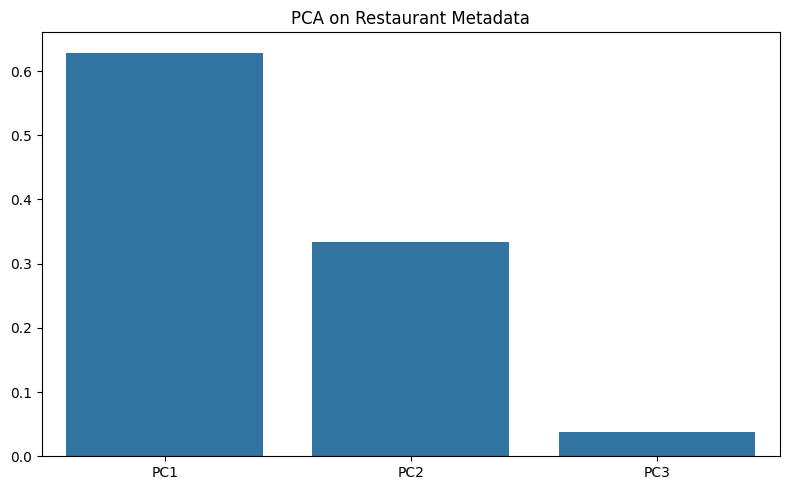

In [69]:
# PCA on Restaurant Metadata
restaurant_features = df_clean[['latitude', 'longitude', 'rating']].dropna()

scaler = StandardScaler()
restaurant_scaled = scaler.fit_transform(restaurant_features)

pca = PCA()
pca_result = pca.fit(restaurant_scaled)

plt.figure(figsize=(8, 5))
sns.barplot(x=[f'PC{i+1}' for i in range(len(pca.explained_variance_ratio_))],
            y=pca.explained_variance_ratio_)
plt.title("PCA on Restaurant Metadata")
plt.tight_layout()
plt.show()

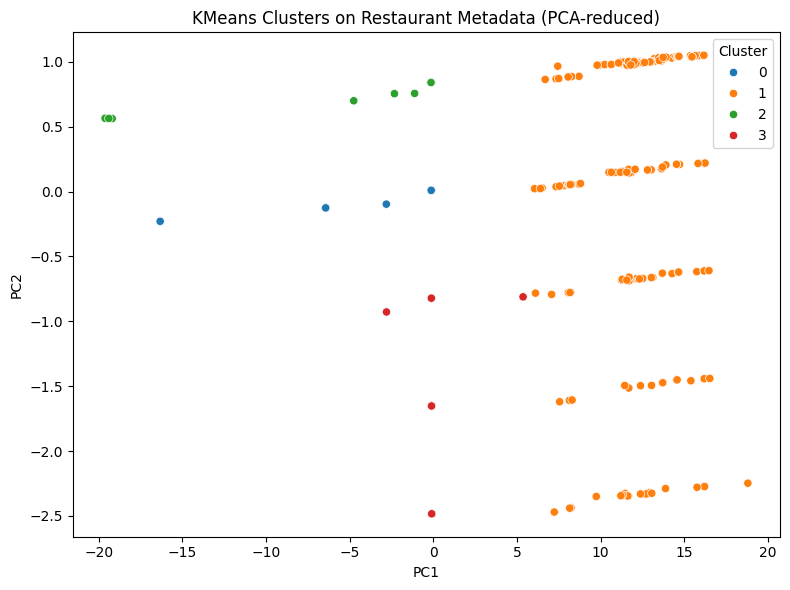

In [ ]:
# Use 2D PCA for clustering
pca_2d = PCA(n_components=2)
restaurant_pca_2d = pca_2d.fit_transform(restaurant_scaled)

# KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(restaurant_pca_2d)

# Visualize clusters
pca_df = pd.DataFrame(restaurant_pca_2d, columns=['PC1', 'PC2'])
pca_df['Cluster'] = clusters

plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', palette='tab10')
plt.title("KMeans Clusters on Restaurant Metadata (PCA-reduced)")
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

restaurant_features = df_clean[['latitude', 'longitude', 'rating']].dropna()
scaler = StandardScaler()
sentiment_scaled = scaler.fit_transform(restaurant_features)
pca = PCA()
pca_result = pca.fit(sentiment_scaled)

used_feature_names = restaurant_features.columns[:pca.components_.shape[1]]
loadings = pd.DataFrame(pca.components_.T,
                        columns=[f'PC{i+1}' for i in range(len(pca.explained_variance_ratio_))],
                        index=used_feature_names)

print("Feature Loadings for PCA:")
print(loadings)

Feature Loadings for PCA:
                PC1       PC2       PC3
latitude   0.707084  0.003684  0.707120
longitude -0.707022 -0.013794  0.707057
rating    -0.012359  0.999898  0.007149


### Step 10: Conclusion


The exploratory data analysis provided a comprehensive understanding of user interactions, restaurant characteristics, and the sentiment landscape within the dataset. The findings highlight several key insights that can guide the development of more effective recommendation systems or decision-making strategies.

---

#### 1. User and Restaurant Behavior

- **User Review Frequency**: Most users left only a single review, indicating a high number of cold-start users. This makes personalization harder due to limited data.
- **Restaurant Review Frequency**: A few restaurants received many reviews, while most had very few, showing a similar cold-start problem on the item side.
- **Matrix Sparsity**: With ~99.81% sparsity, collaborative filtering models alone are not sufficient without additional signals like metadata or content-based features.

---

#### 2.  Long-Tail Effect

- Both user and item review frequencies follow a long-tail distribution.
- A small group of users and restaurants dominate interactions.
- This imbalance suggests the need for methods to manage popularity bias and ensure fairness.

---

#### 3.  Cold-Start Detection

- **Cold-start users (< 2 reviews)**: 1,778 users  
- **Cold-start restaurants (< 2 reviews)**: 19 restaurants  
- This confirms the importance of hybrid recommendation strategies that rely on metadata, location, or popularity fallback.

---

#### 4. Item Metadata Exploration

- **Diversity**: Many types of restaurants are present, with "Restaurant", "Bar", and "Spanish Restaurant" being the most common.
- **Average Rating by Type**: Most types score high, especially mainstream categories. Attractions and parks receive slightly lower ratings, possibly due to visitor expectations.

---

#### 5.  Contextual Patterns

- **Reviews Over Time**: Sharp increase in reviews in 2023–2024 suggests recency bias and active user base in the recent years.
- **Monthly Rating Trends**: Slight variation throughout the year, but generally stable.
- **Sentiment Over Months**: Sentiment remains positive across the year with expected fluctuations, especially around mid-year and holidays.

---

#### 6. Ratings and Review Insights

- **Rating Distribution**: Skewed heavily toward 5 stars, indicating strong positivity bias.
- **Review Lengths**: Most reviews are short (< 100 words), but some lengthy outliers exist.
- **Top Users and Restaurants**: Few users and restaurants dominate, indicating potential for overfitting if not accounted for.

---

#### 7.  Sentiment & Emotion Analysis

- **Sentiment Scores**: Most scores are clustered in the positive range. Value and ambiance tend to show more variation.
- **Emotion Frequency**: Joy, satisfaction, and contentment dominate, while frustration and anger are rare.
- **Word Cloud (All Reviews)**: Common words like *food*, *place*, *service*, *Madrid*, and *staff* show what users prioritize in reviews.
- **Word Cloud (Positive vs. Negative)**: Positive reviews emphasize *delicious*, *friendly*, *great*, while negative reviews still mention similar words but often in a different context.

---

#### 8.  Correlation Analysis

- **Rating vs. Sentiment**: Moderately strong correlations were found (e.g., 0.68 between rating and overall sentiment).
- **Strongest Sentiment Correlations**:
  - `overall_score` ↔ `food_score`: 0.64
  - `rating` ↔ `overall_score`: 0.68
  - Lower correlation for ambiance and value suggests subjective interpretation by users.

---

#### 9. Dimensionality Reduction and Feature Insights

- **PCA on Sentiment Features**: Revealed that the first few principal components (PC1–PC3) capture a large portion of the variance in user sentiment. Notably, `overall_score` and `food_score` contributed most to PC1, suggesting they are the most informative for understanding user sentiment and could be prioritized in recommendation strategies.

- **PCA on Rating-Related Variables**: Showed that a few components can explain most of the variability in user ratings. This indicates potential redundancy among features and allows for a more efficient recommendation model by reducing the number of variables without significant information loss.

- **PCA on Restaurant Metadata**: Demonstrated that key restaurant-level attributes can be compressed into fewer dimensions. This supports the use of metadata in content-based filtering while improving scalability and simplifying computations.

These PCA insights help identify the most valuable features for downstream modeling, enabling simplified architectures and more targeted, effective recommendations.

---

####  Overall Takeaway

- The dataset is highly sparse, with long-tail behavior in user and restaurant activity.
- Reviews are largely positive, supported by both ratings and sentiment.
- Hybrid recommendation strategies should be prioritized to handle cold-start users and items.
- Contextual features (time, type, sentiment, emotion) offer valuable signals for personalization and recommendation accuracy.
- Sentiment analysis and emotion tagging provide rich interpretability for understanding user experiences.

---



#### Implications for the Recommendation System

The insights derived from the EDA strongly suggest that a **hybrid recommendation system** would be the most effective approach for this dataset. Given the high sparsity (~99.81%) and the prevalence of cold-start users and restaurants, relying solely on collaborative filtering would lead to poor performance and limited personalization. Incorporating **content-based filtering**, leveraging metadata such as restaurant type, location, and contextual features like time of review and sentiment, can greatly enhance recommendations. Additionally, **sentiment scores and emotional signals** can be used to enrich the user profile or refine item similarities, helping tailor suggestions that go beyond numerical ratings. Temporal patterns and review trends could further inform **time-aware recommendations**, ensuring relevance in seasonal or event-driven contexts. Overall, combining these signals within a hybrid framework allows for more robust, accurate, and fair recommendations even when data is sparse or user history is limited.
